In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Reading Data

In [2]:
data= pd.read_csv('nyc_taxi_trip_duration.csv')
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

### Data Variables

- __id__ - a unique identifier for each trip
- __vendor_id__ - a code indicating the provider associated with the trip record
- __pickup_datetime__ - date and time when the meter was engaged
- __dropoff_datetime__ - date and time when the meter was disengaged
- __passenger_count__ - the number of passengers in the vehicle (driver entered value)
- __pickup_longitude__ - the longitude where the meter was engaged
- __pickup_latitude__ - the latitude where the meter was engaged
- __dropoff_longitude__ - the longitude where the meter was disengaged
- __dropoff_latitude__ - the latitude where the meter was disengaged
- __store_and_fwd_flag__ - This flag indicates whether the trip record was held in vehicle memory before sending to the - vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- __trip_duration__ - (target) duration of the trip in seconds

In [3]:
data.shape

(729322, 11)

## Data types

In [4]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

- Customer id is a randomly assigned unique identifier for a trip. So it can remain as an object.
- Vendor_id represents an id of the provider. This should be a category.
- Store_and_fwd_flag is object data type. But since we have only two possible values, it can be treated as a category.

In [5]:
data['vendor_id']= data['vendor_id'].astype('category')
data['store_and_fwd_flag']= data['store_and_fwd_flag'].astype('category')

## Feature extraction

### Pick-up and drop-off time

Since pickup and drop off time need to be analyzed for time of the day, day of the week etc., these variables need to be converted to date time object for feature extraction.

It may be interesting to look at the following attributes of the date time variables.

- year- Is it all 2016? If so, it may be dropped as it will not add any value.
- month- To identify any seasonality in traffic, weather conditions etc.,
- weekday- To see if weekends/weekdays and certain days of the week can account for variabilities
- Hour and minutes- Hour and minute of the day may capture some variabilities in trip duration with certain hours being peak


In [6]:
#Conversion
pickup_date= pd.DatetimeIndex(data['pickup_datetime'])
dropoff_date= pd.DatetimeIndex(data['pickup_datetime'])

In [7]:
#day of year of pick up 
data['year_pickup']= pickup_date.year

#Month of year of pick up
data['month_pickup']= pickup_date.month

#Week day of pick up
data['weekday_pickup']= pickup_date.weekday

#Hour of pick up
data['hour_pickup']= pickup_date.hour

#Minute of pick up
data['minute_pickup']= pickup_date.minute

In [8]:
data['pickup_time']= pd.to_datetime(data.pickup_datetime)
data['dropoff_time']= pd.to_datetime(data.dropoff_datetime)


### Distance estimation

Apart from the pick-up and drop-off attributes, another key variable that can be influential in calculating trip duration is the distance. Since we have the latitude and longitude in the problem statement, we use **geopy** library to calculate distance between the pickup and drop-off locations. 

In [9]:
import geopy.distance
def distance_miles(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geopy.distance.geodesic(coords_1, coords_2).miles

data['pickup_dropoff_distance'] = data.apply(distance_miles, axis=1)

### Any irrelevant features?

In [10]:
#Is the year of pick up all 2016?

data['year_pickup'].unique()

array([2016])

The entire column of year has only 1 value: **2016**. \
Hence, this column can be dropped.

We can also remove the pickup_datetime and dropoff_datetime objects since we have extracted necessary features from these attributes.
Also removing the id column since it is a randomly generated unique identifier for the trip.

In [11]:
#Is the trip duration simply the delta of the time between the time when meter was engaged and disengaged?
t1= pd.to_datetime(data.pickup_datetime)
t2= pd.to_datetime(data.dropoff_datetime)
dt= t2-t1
delta_seconds = dt / np.timedelta64(1, 's')
sum(delta_seconds- pd.Series(data.trip_duration))

0.0

Since the time duration is simply a difference between pick up and drop-off, and given that we are trying to gain insights on how the independent variables may influence the trip duration (the dependent variable), the drop-off time may not provide any value and may be dropped. 

But let us retain it for now, in case this is required to analyze any missing values/outliers.

In [12]:
data= data.drop(columns=['year_pickup', 'id', 'pickup_datetime', 'dropoff_datetime'])

In [13]:
data.dtypes

vendor_id                        category
passenger_count                     int64
pickup_longitude                  float64
pickup_latitude                   float64
dropoff_longitude                 float64
dropoff_latitude                  float64
store_and_fwd_flag               category
trip_duration                       int64
month_pickup                        int64
weekday_pickup                      int64
hour_pickup                         int64
minute_pickup                       int64
pickup_time                datetime64[ns]
dropoff_time               datetime64[ns]
pickup_dropoff_distance           float64
dtype: object

In [14]:
numerical_cols= [cols for cols in data.columns if (data[cols].dtypes== 'int') | (data[cols].dtypes== 'float64')]
numerical_cols

['passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'month_pickup',
 'weekday_pickup',
 'hour_pickup',
 'minute_pickup',
 'pickup_dropoff_distance']

In [15]:
#Printing the rage of all numerical columns
for col in numerical_cols:
    print(f"The range of {col}: [{data[col].min()}, {data[col].max()}]")

The range of passenger_count: [0, 9]
The range of pickup_longitude: [-121.93334197998048, -65.89738464355469]
The range of pickup_latitude: [34.71223449707032, 51.88108444213867]
The range of dropoff_longitude: [-121.9333038330078, -65.89738464355469]
The range of dropoff_latitude: [32.1811408996582, 43.92102813720703]
The range of trip_duration: [1, 1939736]
The range of month_pickup: [1, 6]
The range of weekday_pickup: [0, 6]
The range of hour_pickup: [0, 23]
The range of minute_pickup: [0, 59]
The range of pickup_dropoff_distance: [0.0, 770.8173365229512]


- There can be anywhere between 0 to 9 passengers in a trip. It may be worth exploring further what those trips with passenger counts like 0 and 9 are since these look like unusual passenger count for a taxi.
- There is a wide range of latitude and longitude which may also be worth exploring since new york city and the surrounding counties cannot account for such large ranges in latitudes and longitudes.
- We have monthly data only from January to June. So we may not be able to account for all kinds of monthly seasonalities.
- Unusual trip_duration and pickup_dropoff_distance at the upper end may also be worth exploring further.

## Univariate Analysis of variables

### Count of the discrete and categorical features

In [16]:
def countplot(feature, figsize= (10,5)):
    feature_count = data[feature].value_counts()
    fig = plt.figure(figsize=figsize, dpi=200)
    ax= sns.barplot(x=feature_count.index, y=feature_count.values)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    for p in ax.patches:
            ax.annotate('{:1.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')
    plt.show()
    

### Passenger Count

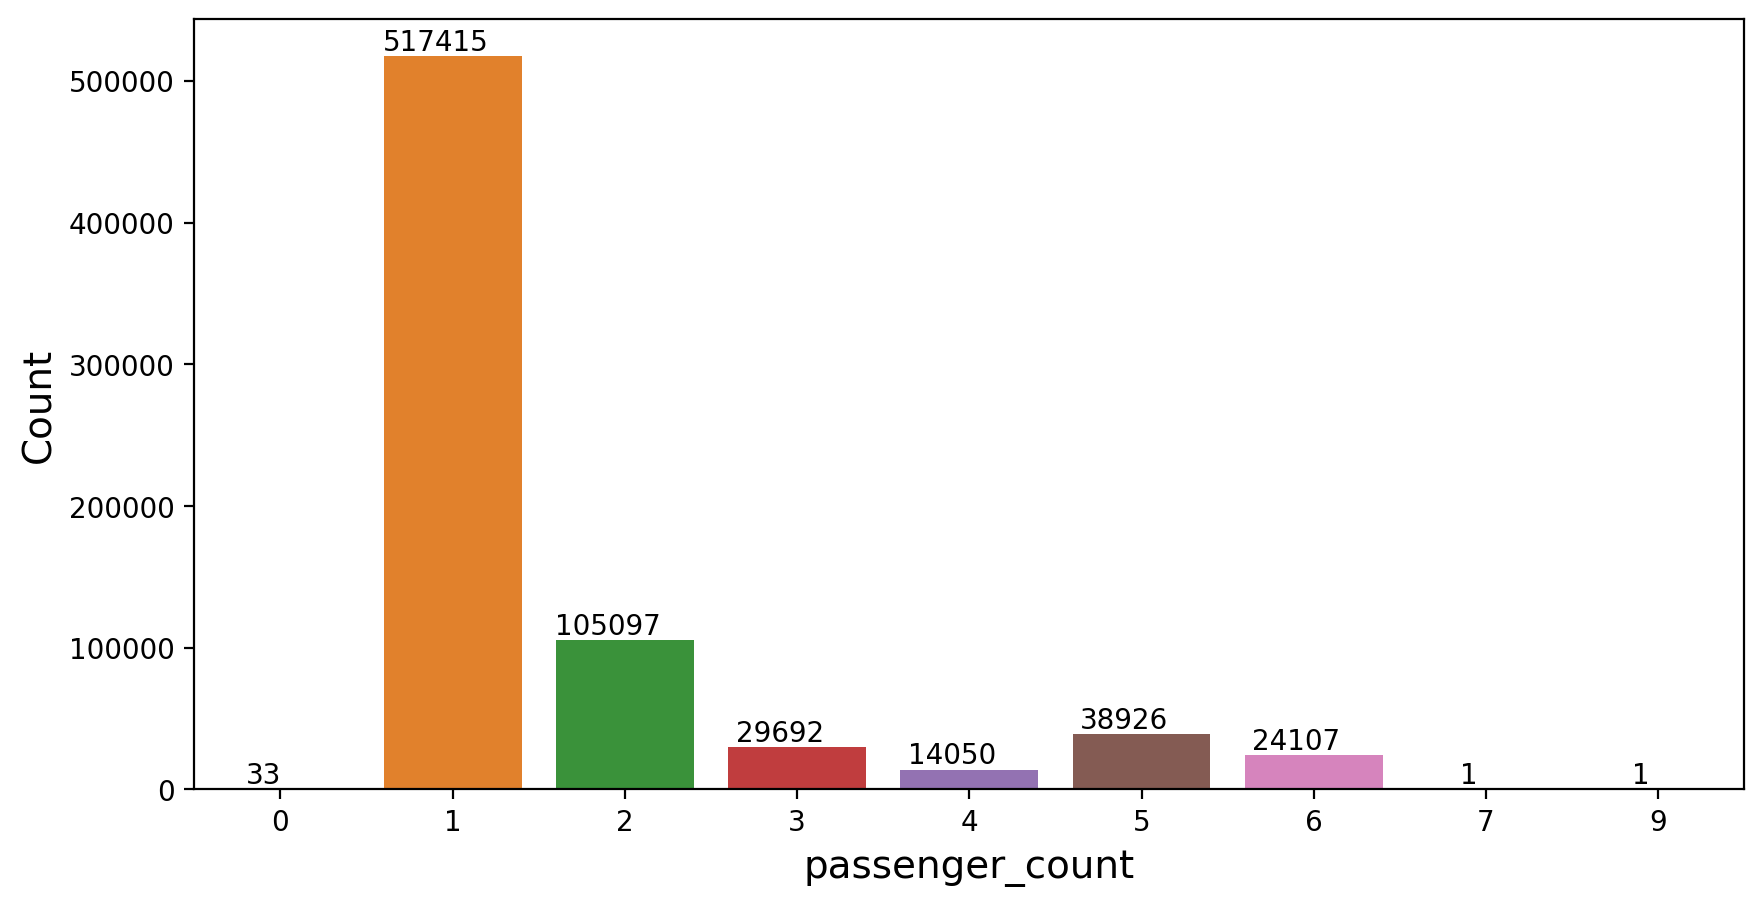

In [17]:
countplot("passenger_count")

Passenger Count= 1 has is significantly the highest number. We may need to replace the passenger counts of 0,7 & 9 as they look unrealistic. Very low in number, so could be an error in recording the value.

### Vendor_id

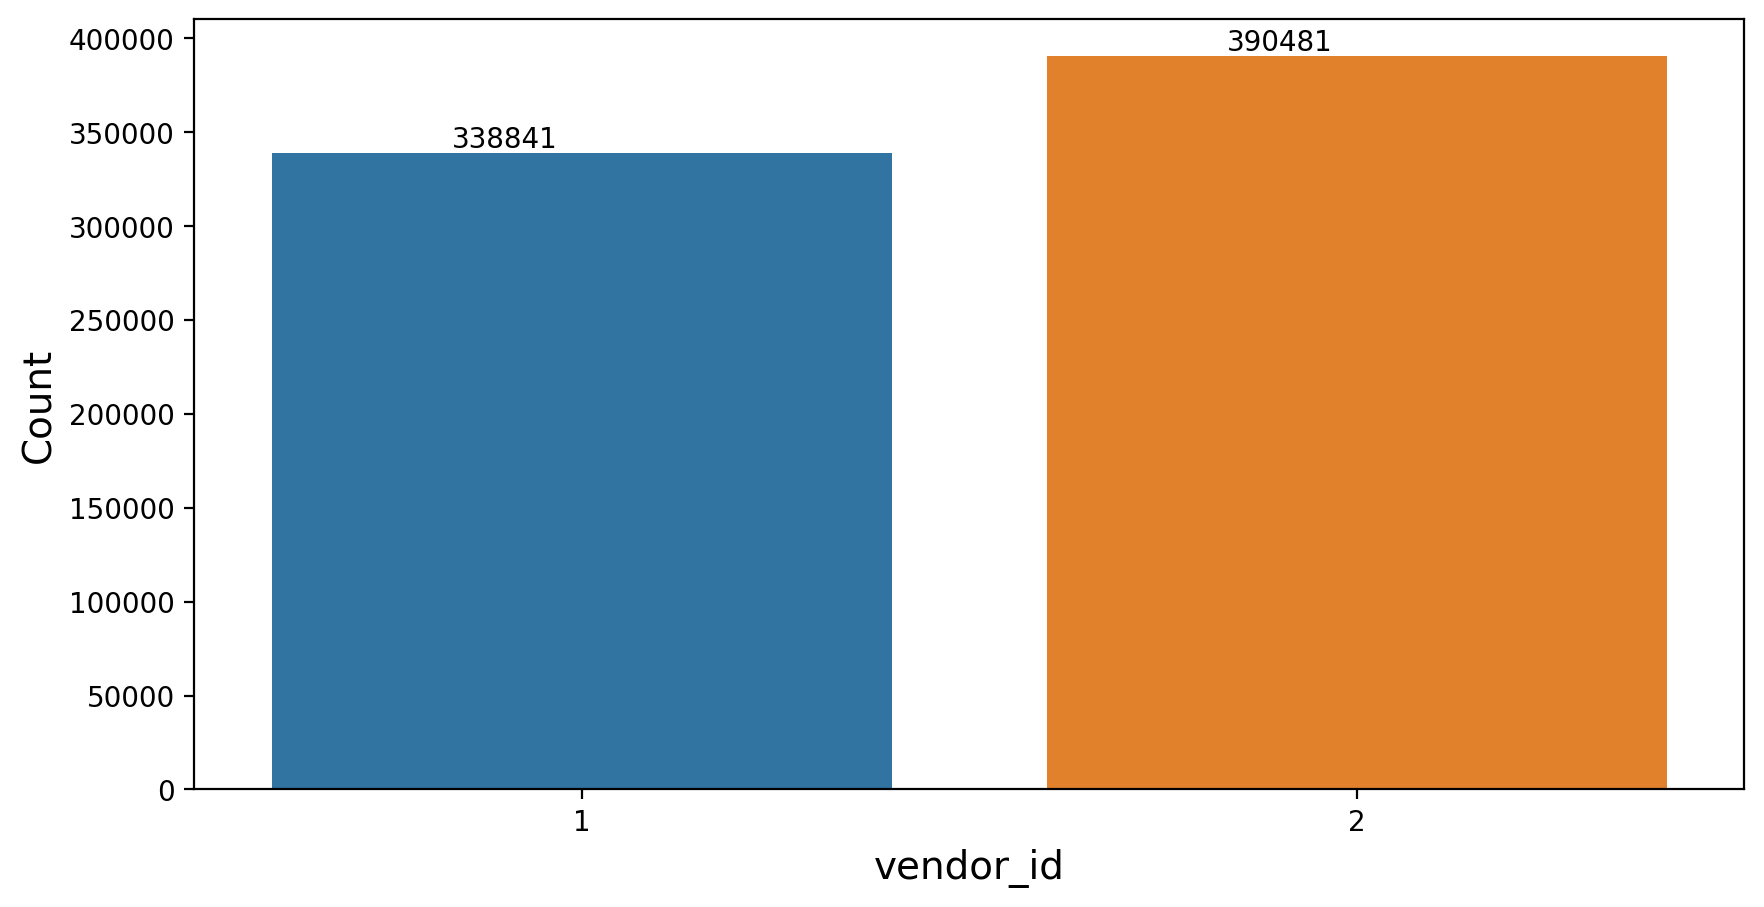

In [18]:
countplot("vendor_id")

Nothing interesting to see here. As part of bi-variate and multi-variate analysis, it might be worth looking at the following.
- Does the __average trip duration__ vary by __vendor_id__
- If the __trip duration__ does vary with vendor_id, is it influenced by the __zone__ in which they operate? We may need to extract information on geographical locations from GPS coordinates to derive this insight.
- Does any of the vendor_IDs contribute predominantly to outliers in trip duration which could possibly be error in the recording system of the respective vendor.

### Store_and_fwd_flag

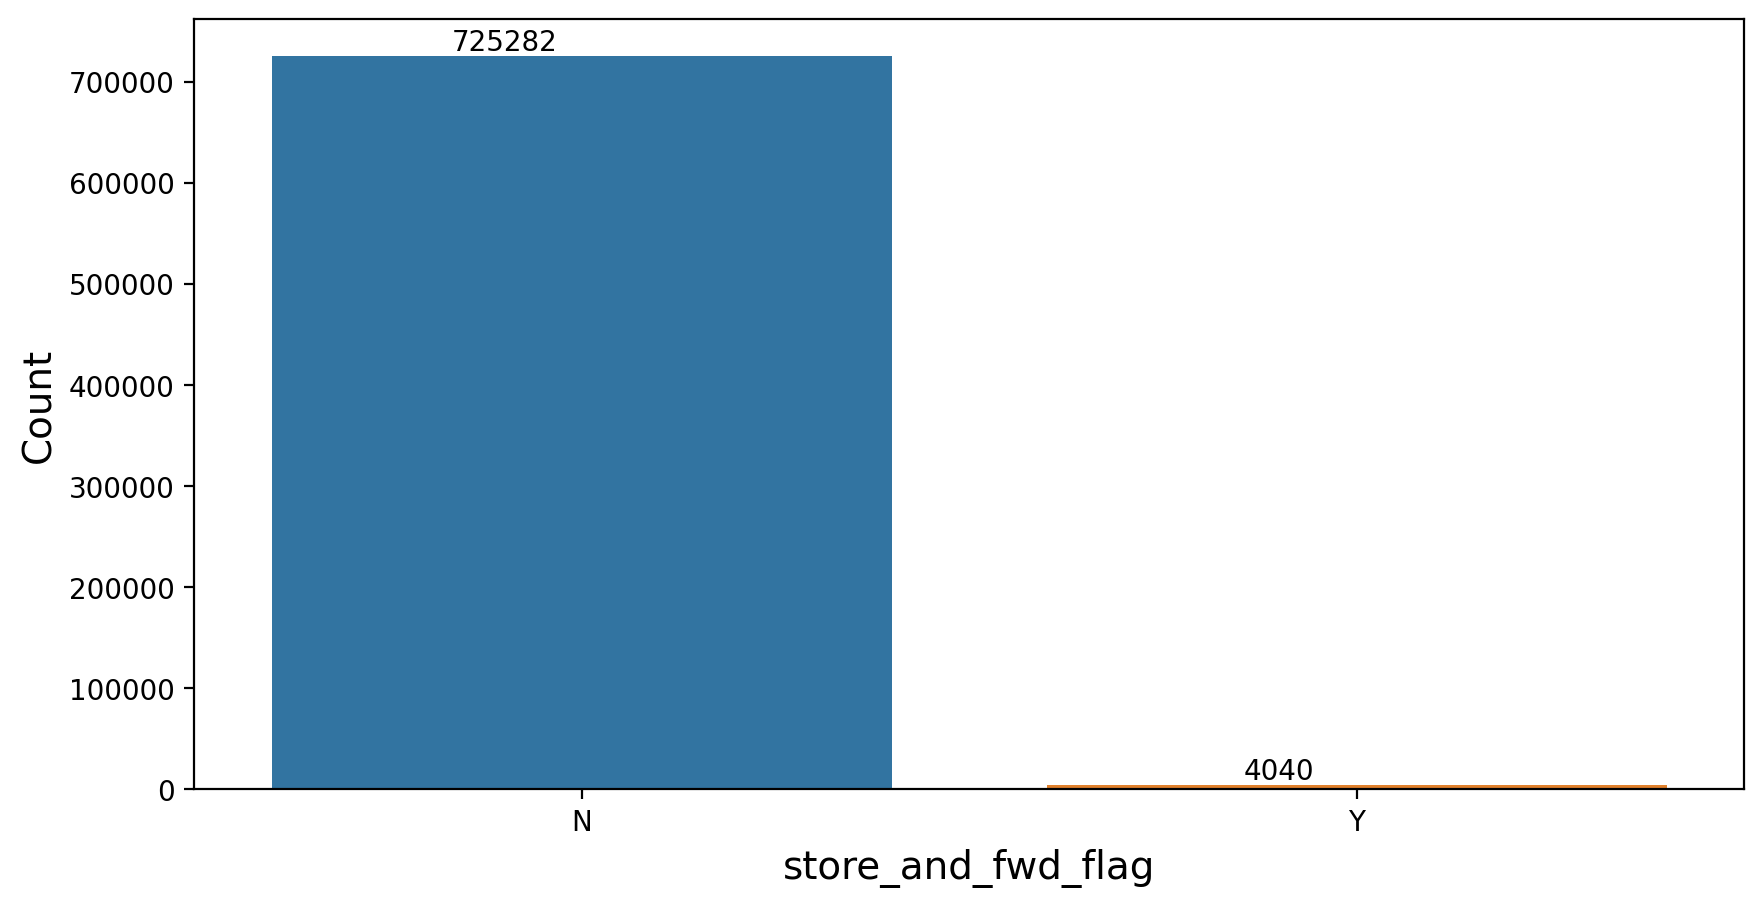

In [19]:
countplot("store_and_fwd_flag")

Only very few trips have a __store_and_fwd_flag__= Yes where the vehicle did not have connection to the server. Following maybe worth looking at.

Could such trips be affected by bad weather and have a higher trip duration between same or similar pick-up drop-off points?

### Month_pickup

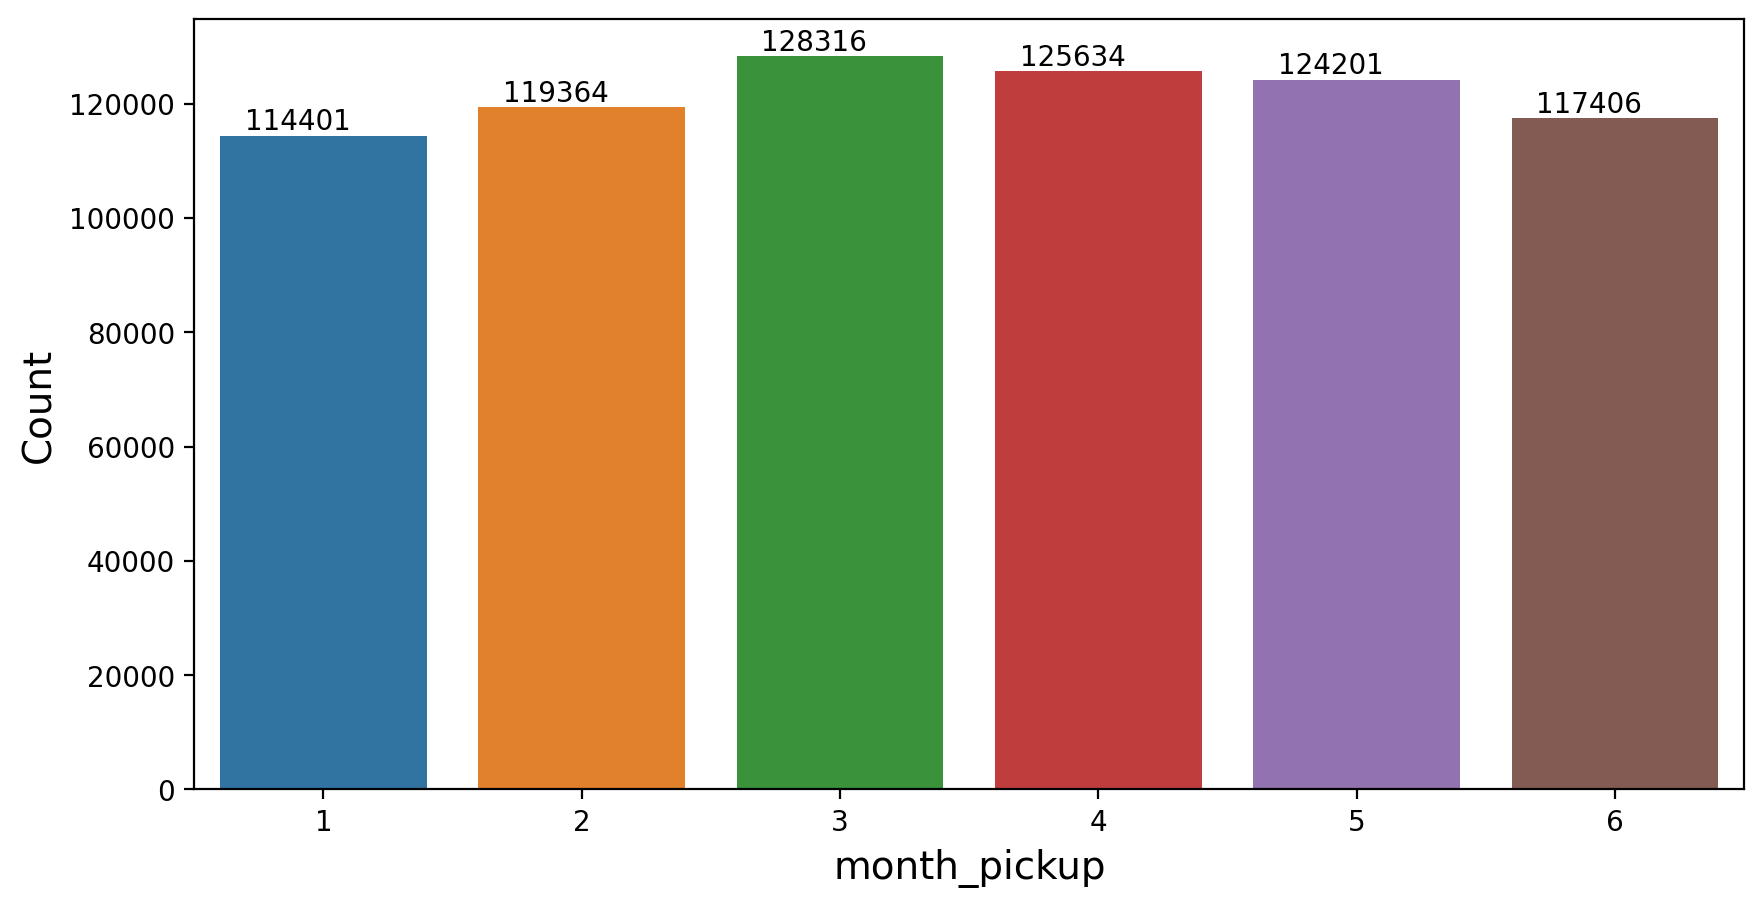

In [20]:
countplot('month_pickup')

The distribution is quite uniform. We do not see any major uptick in numbers in any month.

This could potentially mean the day-to-day trips of daily commuters to and from work account of substantial proportion of the trips as this is unaffected by seasonality. 

A slight uptick in March could be related to the spring break season when a lot of people travel around the country. But to test this hypothesis, we may need to see if there are trips to airports like JFK, EWR etc.,

__So majority of the trips in the data set could be short duration work trips within the city. We need to check this further__

### Week day of pickup

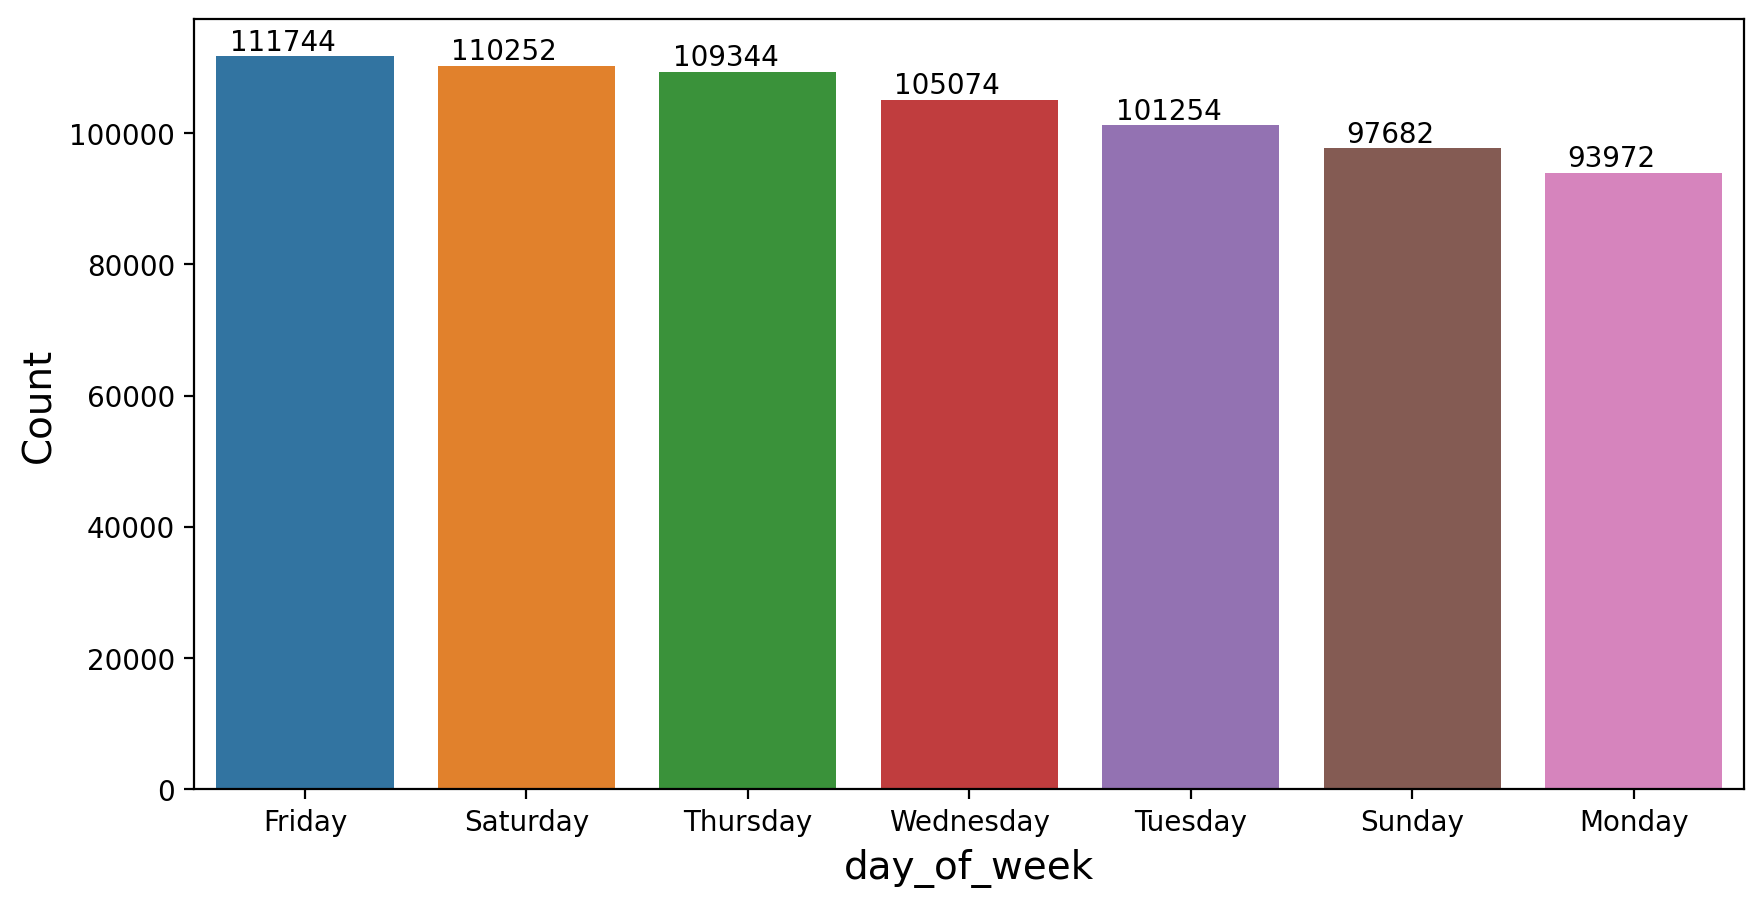

In [21]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['day_of_week'] = data['weekday_pickup'].map(lambda x: day_names[x])
countplot('day_of_week')
data= data.drop('weekday_pickup', axis=1) #We can use these labels instead

It looks like thursday, friday and saturday have higher number of commuters than monday and sunday. So the earlier hypothesis that majority of the trips are 'work-related' maybe **wrong**. We can check the following.


Are there lot of trips after workhours?This could mean the cab service is quite frequently used for trips to restaurants/pubs after work and then back home. If so, it would explain the high number of trips on friday and saturday.


### Hour of pickup

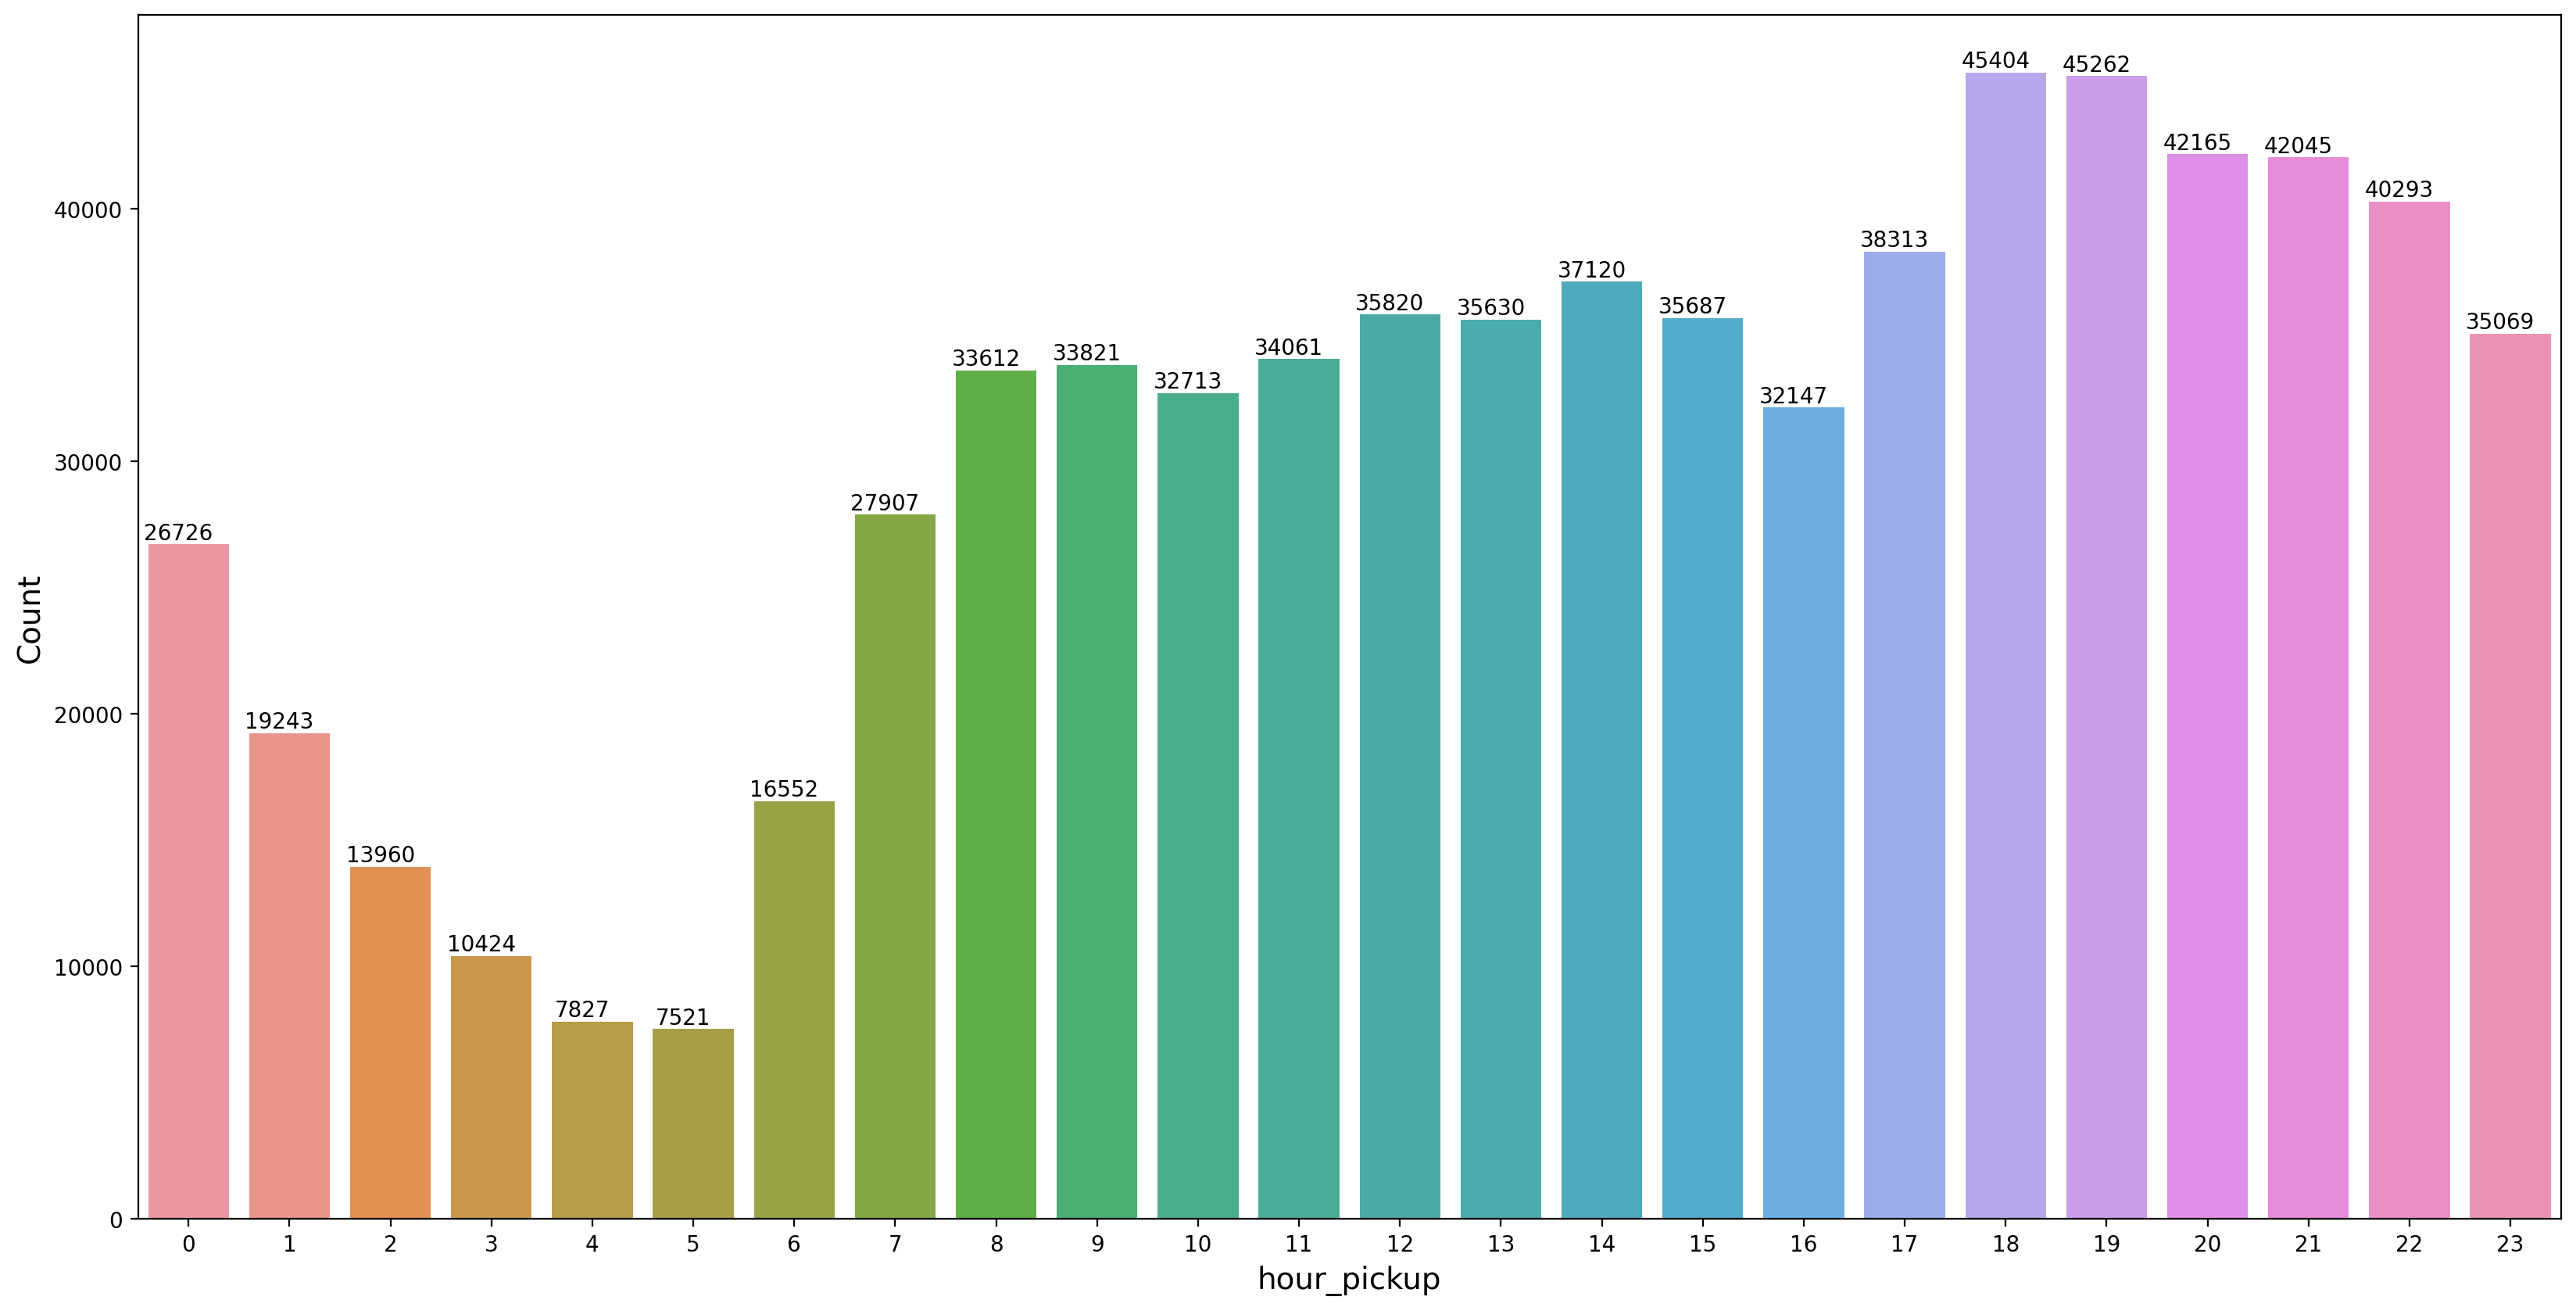

In [22]:
countplot('hour_pickup',figsize= (20,10))

As can be seen from the graph, there is a major uptick in trip count after 6 PM.
Let us assume the cab service could be used for the following by the people in New York city. 

- **Aiport**: But flight density at JFK is uniform throughout the day. As per the popular times for the airport tracked by google, there is not much difference in trip density to airports between say 3 PM and 9 PM. So this variability is not necessarily accounted for by number of people visiting airport. To test this further, we will need the coordinates of prominent airports in NYC.


- **Daily commute to and from work**: If this was the major contributor, we would see similar numbers in the morning, say 7 AM to 9 AM as seen for 5 PM to 8 PM. If the daily commuters were dominant contributors, you could expect to see similar numbers in the morning as well. Also, there would be similar distribution throughout the week. Even though the numbers around 8 AM are significantly higher than 6 AM, it is still not as high as 6 PM or 7 PM.


- **Commute to restaurants/pubs in the city and back home**: This looks plausible as the dominant contributor to the number of cab trips. This is supported by the fact that highest number of trips happen towards the backend of the week (thursday, friday and saturday) and the higher number of trips after 6 PM which tapers off till early morning.


**Note: It is not worth exploring the minute variable as it is too granular a feature worth deriving any insight from and should not have any impact on trip duration**

### Summary of the pickup time variable insights

- Not much insight on seasonality could be derived from the months variable since we do not have data for trips throughout the year. It maybe worth tagging coordinates of major airports to see if they contribute to an uptick to trip in March, as this is the time of spring break in US. If it does indeed contribute to an uptick in trips in March, a similar trend could be anticipated in July and August which are holiday seasons in US.


- Week day of the trip suggests the cab is used most frequently in the back-end of the week (Thursday, Friday and Saturday) and therefore it may possibly not be due to daily commute to work.


- The cab service is most frequently used after office hours. These could be commutes to restaurants/pubs and back home. The fact that trips are most frequent during fridays and saturdays validates this.

**As part of multi-variate analysis, we could look at most popular hours by day of the week**

### Univariate Distribution of numeric variables

In [23]:
# custom function for easy and efficient analysis of numerical univariate

def UVA_numeric(data, var_group):
  ''' 
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(x=data[i], shade=True)
    sns.lineplot(x=points, y=[0,0], color = 'black', label = "std_dev")
    sns.scatterplot(x=[mini,maxi], y=[0,0], color = 'orange', label = "min/max")
    sns.scatterplot(x=[mean], y=[0], color = 'red', label = "mean")
    sns.scatterplot(x=[median], y=[0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('within 1 std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

In [24]:
gps_variables= ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

speed_related_variables= ['trip_duration','pickup_dropoff_distance' ]

### Pick-up and drop-off locations

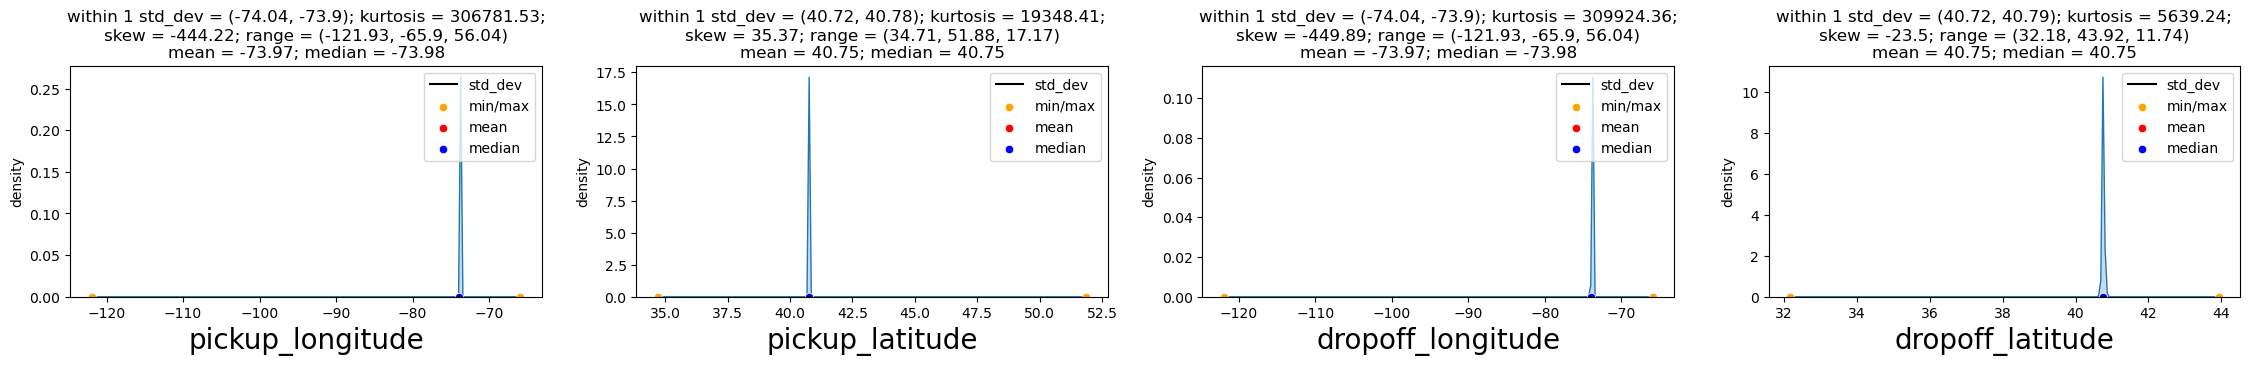

In [25]:
UVA_numeric(data,gps_variables)

Extremely high skew and kurtosis suggests presence of large outliers. Such outliers in latitudes and longitudes may suggest some of these locations may actually lie very much outside of New York. 

A range of 56.04 and 11.74 in longitude and latitude respectively is unusual for a city. We may need to see some of these points.

It is interesting to note that the 1 standard deviation for latitudes and longitudes for both pick-up and drop-off are same- (40.72, 40.78) and (-74.04, -73.9) respectively. This could serve as a reliable benchmark for the coordinates of operation of the cab service. 

Also, since mean and median are similar across the 4 plot, it could mean that although these are **qualitatively** big outliers, the **quantity** of such outliers maybe low and therefore does not impact the mean much. 

1. Such trips to and from abnormal coordinates are relatively low in number for it to be a route of operation of the taxi and therefore these coordinates are probably bad data. We can confirm it by checking some of these locations. 
2. Since they are small in number we could remove them and not lose much data. 

The above two need to be verified


Let us look at some of the locations with extreme coordinates using **reverse_geocoder**. 

Reverse_geocoder is a library that enables us to use coordinates and provide estimate of town, county, administrative area etc.,

In [26]:
import reverse_geocoder as rg

def fetch_city(coordinate, point, which_extreme,data= data):
    """
    Fetch pickup or drop-off point and find extreme values
    """
    if which_extreme== 'max':
        coordinates = (data[data[f'{point}_{coordinate}']== data[f'{point}_{coordinate}'].max()][f'{point}_latitude'].values[0]
                      ,data[data[f'{point}_{coordinate}']== data[f'{point}_{coordinate}'].max()][f'{point}_longitude'].values[0])
    elif which_extreme== 'min':
        coordinates = (data[data[f'{point}_{coordinate}']== data[f'{point}_{coordinate}'].min()][f'{point}_latitude'].values[0]
                      ,data[data[f'{point}_{coordinate}']== data[f'{point}_{coordinate}'].min()][f'{point}_longitude'].values[0])
        

    return (rg.search(coordinates)[0])['admin1']

In [27]:
extreme_coordinates= []
for i in ['latitude', 'longitude']:
    for j in ['pickup', 'dropoff']:
        for k in ['max', 'min']:
            extreme_coordinates.append(fetch_city(i,j,k))
            
print(extreme_coordinates)        

Loading formatted geocoded file...
['Quebec', 'North Carolina', 'Ontario', 'North Carolina', 'Nova Scotia', 'California', 'Nova Scotia', 'California']


As initially suspected, the extreme coordinates do not look like good data. These coordinates span across locations like California (which is on the other coast), North Carolina  and certain provinces in Canada like Nova Scotia, Quebac and Ontario. 

If this is a locally operated cab service, it is unlikely to have such coordinates. So these may be examples of **bad data**.

### Removing outliers above and below 3 SD to visualize the plots for GPS coordinates

In [28]:
# standard deviation factor
factor = 3

# copying data with required 
gps_data = data[gps_variables]

# filtering using standard deviation (not considering obseravtions greater than or less than 3* standard deviation)
gps_data = gps_data[(gps_data['pickup_latitude'] < (gps_data['pickup_latitude'].mean() + factor*gps_data['pickup_latitude'].std()))
                   & (gps_data['pickup_latitude'] > (gps_data['pickup_latitude'].mean() - factor*gps_data['pickup_latitude'].std()))]
gps_data = gps_data[(gps_data['pickup_longitude'] < (gps_data['pickup_longitude'].mean() + factor*gps_data['pickup_longitude'].std()))
                   & (gps_data['pickup_longitude'] > (gps_data['pickup_longitude'].mean() - factor*gps_data['pickup_longitude'].std()))]
gps_data = gps_data[(gps_data['dropoff_latitude'] < (gps_data['dropoff_latitude'].mean() + factor*gps_data['dropoff_latitude'].std()))
                   & (gps_data['dropoff_latitude'] > (gps_data['dropoff_latitude'].mean() - factor*gps_data['dropoff_latitude'].std()))]
gps_data = gps_data[(gps_data['dropoff_longitude'] < (gps_data['dropoff_longitude'].mean() + factor*gps_data['dropoff_longitude'].std()))
                   & (gps_data['dropoff_longitude'] > (gps_data['dropoff_longitude'].mean() - factor*gps_data['dropoff_longitude'].std()))]


# checking how many points removed
len(data), len(gps_data)

(729322, 663117)

It looks like we will remove a significant portion of data if we simply remove every data point which is beyond 3 standard deviation from mean (approximately ~10%). Hence, we may need to do further deep dive before dropping outliers. 

Maybe we could use inter-quartile range? 

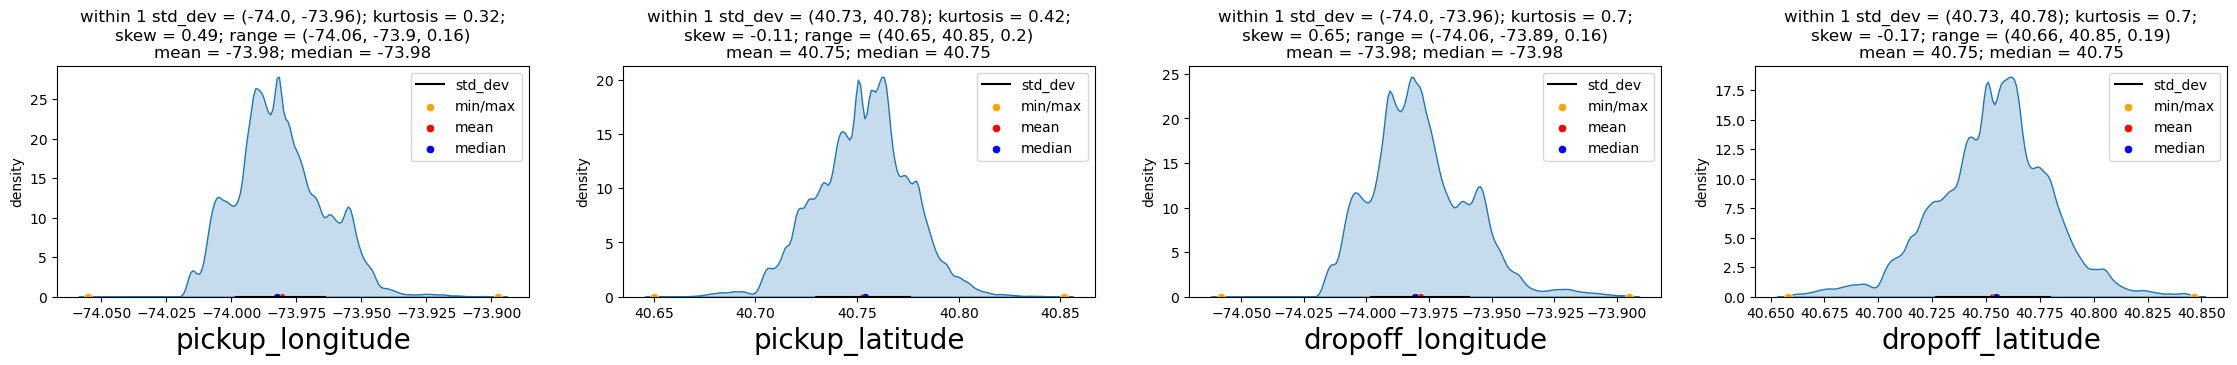

In [29]:
UVA_numeric(gps_data,gps_variables)

This looks better. The range of latitude and longitudes are limited to within 0.2. But we need to do further analysis on outliers before they are removed.

### More on Pick up and drop-off GPS coordinates

These variables are very relevant to the problem but maybe tricky to gain insights from. One meaningful way to interpret results from these coordinates maybe to split them into clusters based on latitude/longitude and assigning cluster value to pickup and drop-off location. This will enable us to segment the city into zones and certain zones may have more traffic in and out of it. For instance, the trip duration within downtown Manhattan during peak hours may be substantially high.

By doing so, we will have the following. 
1. distance (as derived above) which will give us an absolute measure of effort that influences the trip duration 

2. zones of the city (based on clusters) that will give us a relational measure based on traffic, rush hour density, direction of traffic etc.,

**This will be done as part of bivariate analysis**

### Trip Duration and distance

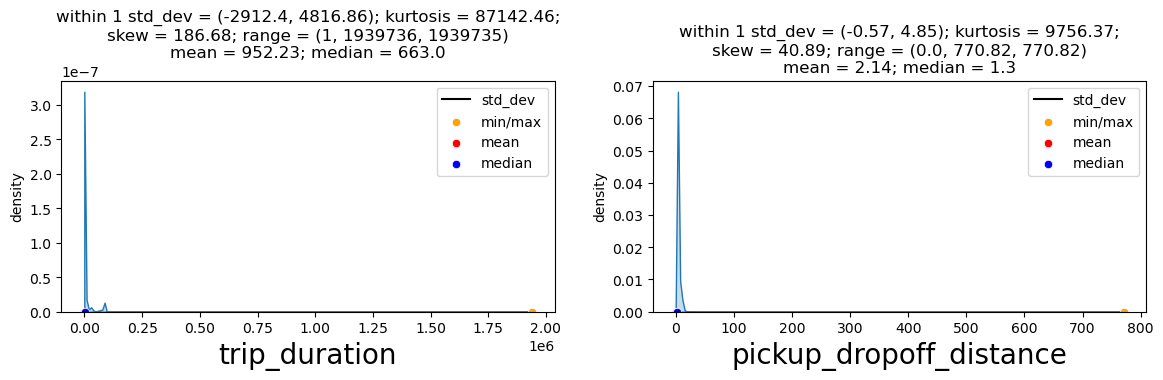

In [30]:
UVA_numeric(data,speed_related_variables)

Similar to the coordinates, there are some large outliers in the data. Lower limit on the range (1 second and 0 miles respectively) may not be incorrect. But these could represent trips that were cancelled and wrongfully marked as completed. We need to test this further.

In [31]:
#Shortest trip details
data[data['trip_duration']== data['trip_duration'].min()]

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
70318          2                1        -73.945999        40.792202   
95823          2                1        -73.975677        40.785488   
102646         1                1        -73.940384        40.786423   
119181         1                1        -73.861961        40.768559   
296874         1                1        -73.819893        40.740822   
312992         1                1        -73.980690        40.744419   
323299         1                1        -73.980560        40.754829   
398887         1                1        -73.789658        40.647003   
512833         2                2        -73.983154        40.767159   
533760         2                0        -73.987595        40.719997   
566349         1                1        -73.987991        40.724083   
622664         1                1        -73.986282        40.750034   
672240         1                1        -73.807213        40.658192   

        dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
70318          -73.947411         40.792740                  N              1   
95823          -73.976372         40.785831                  N              1   
102646         -73.940300         40.786373                  N              1   
119181         -73.861961         40.768559                  N              1   
296874         -73.819885         40.740822                  N              1   
312992         -73.980690         40.744419                  N              1   
323299         -73.980560         40.754829                  N              1   
398887         -73.789658         40.647003                  N              1   
512833         -73.983238         40.767097                  N              1   
533760         -73.987595         40.720005                  N              1   
566349         -73.987991         40.724079                  N              1   
622664         -73.986237         40.750088                  N              1   
672240         -73.807259         40.658051                  N              1   

        month_pickup  hour_pickup  minute_pickup         pickup_time  \
70318              4           19              1 2016-04-11 19:01:35   
95823              1           16             55 2016-01-03 16:55:44   
102646             4           11             44 2016-04-17 11:44:49   
119181             1            0             28 2016-01-09 00:28:55   
296874             5            9              3 2016-05-17 09:03:38   
312992             3           16             12 2016-03-07 16:12:28   
323299             2           12             35 2016-02-03 12:35:22   
398887             4            0             28 2016-04-30 00:28:45   
512833             3           12             55 2016-03-27 12:55:52   
533760             2            0             40 2016-02-22 00:40:25   
566349             2           13             40 2016-02-06 13:40:27   
622664             4           23             15 2016-04-20 23:15:08   
672240             1            5             53 2016-01-20 05:53:45   

              dropoff_time  pickup_dropoff_distance day_of_week  
70318  2016-04-11 19:01:36                 0.082804      Monday  
95823  2016-01-03 16:55:45                 0.043442      Sunday  
102646 2016-04-17 11:44:50                 0.005575      Sunday  
119181 2016-01-09 00:28:56                 0.000000    Saturday  
296874 2016-05-17 09:03:39                 0.000400     Tuesday  
312992 2016-03-07 16:12:29                 0.000000      Monday  
323299 2016-02-03 12:35:23                 0.000000   Wednesday  
398887 2016-04-30 00:28:46                 0.000000    Saturday  
512833 2016-03-27 12:55:53                 0.006093      Sunday  
533760 2016-02-22 00:40:26                 0.000526      Monday  
566349 2016-02-06 13:40:28                 0.000263    Saturday  
622664 2016-04-20 23:15:09                 0.004399   Wednesda

Some of these trips seem to have ended in 1 second. These could either be trips that got cancelled immediately after the pickup. The pickup_dropoff distances are pretty close too. 

In [32]:
#Longest trip details
data[data['trip_duration']== data['trip_duration'].max()]

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
21813         1                1         -73.78965        40.643559   

       dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
21813          -73.95681         40.773087                  N        1939736   

       month_pickup  hour_pickup  minute_pickup         pickup_time  \
21813             1            0             19 2016-01-05 00:19:42   

             dropoff_time  pickup_dropoff_distance day_of_week  
21813 2016-01-27 11:08:38                 12.52699     Tuesday

The trip duration here is 1.939 million seconds which is clearly an incorrect value, since it would mean the customer spend many days for a trip of 12.52 miles. The drop-off time may have been recorded incorrectly in this case.

- Are there more such rows with similar data quality issue?
- Of all the data points, what is the largest distance?

In [33]:
data[data['pickup_dropoff_distance']== data['pickup_dropoff_distance'].max()]

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
244913         1                1        -72.809669        51.881084   

        dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
244913         -73.987228         40.750599                  N            792   

        month_pickup  hour_pickup  minute_pickup         pickup_time  \
244913             5           18             58 2016-05-07 18:58:53   

              dropoff_time  pickup_dropoff_distance day_of_week  
244913 2016-05-07 19:12:05               770.817337    Saturday

This looks incorrect too. The distance calculated is 770 miles, but the trip duration is 792 seconds. It is difficult to say which one is incorrect- the coordinates that we used to calculate distance or the trip duration?.

We could do the following.
- Plot the univariate distributions of time and distance by removing outliers.
- Create a third variable- **speed**, by using the formula **speed= distance/time** and identify the rows that have unrealistic values. This might help us identify some clear data issues. For instance, a speed of more than 200 mile/hour may be unrealistic in New York.

### Removing outliers above and below 2 SD to visualize the plots for the time and distance


In [34]:
# standard deviation factor
factor = 3

# copying data with required variables
speed_data = data[speed_related_variables]

# filtering using standard deviation (not considering obseravtions > 2* standard deviation)
speed_data = speed_data[speed_data['trip_duration'] < (speed_data['trip_duration'].mean() + factor*speed_data['trip_duration'].std())]
speed_data = speed_data[speed_data['pickup_dropoff_distance'] < (speed_data['pickup_dropoff_distance'].mean() + factor*speed_data['pickup_dropoff_distance'].std())]

# checking how many points removed
len(data), len(speed_data)

(729322, 708682)

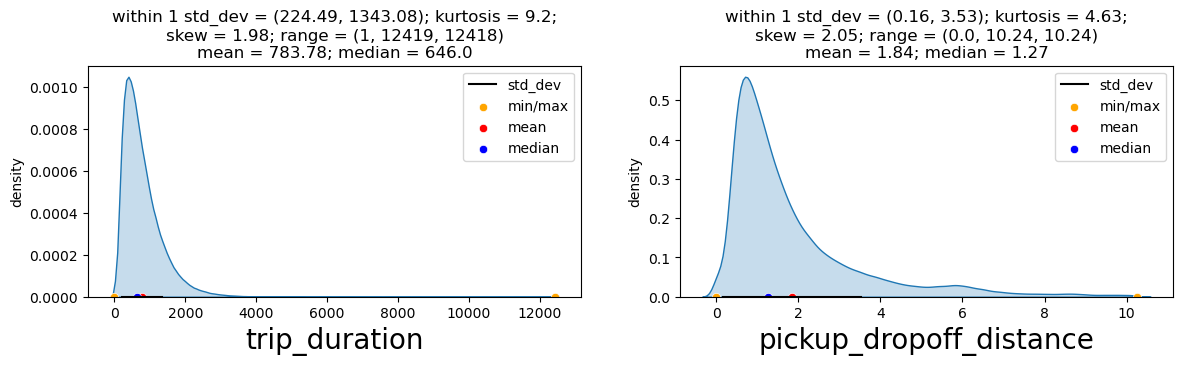

In [35]:
UVA_numeric(speed_data,speed_related_variables)

This is a lot less skewed now, but these are still leptokurtic distributions as demonstrated by the kurtosis. But it is possible that these are actual trips. A trip of 12k seconds which is roughly 3.3 hours is not unrealistic in rush hours in New York. 

### New variable- Average speed

In [36]:
def avg_speed(row):
    time_in_hours = row['trip_duration']/3600
    avg_speed= row['pickup_dropoff_distance']/time_in_hours
    return avg_speed

data['avg_speed'] = data.apply(avg_speed, axis=1)

### Missing Values

In [37]:
data.isna().sum()

vendor_id                  0
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration              0
month_pickup               0
hour_pickup                0
minute_pickup              0
pickup_time                0
dropoff_time               0
pickup_dropoff_distance    0
day_of_week                0
avg_speed                  0
dtype: int64

No missing values observed.

## Bivariate Analysis: Numerical- Numerical variables

In [38]:
numerical= data.select_dtypes(include= ['int64','float64', 'Int64'])[:]
numerical.dtypes

passenger_count              int64
pickup_longitude           float64
pickup_latitude            float64
dropoff_longitude          float64
dropoff_latitude           float64
trip_duration                int64
month_pickup                 int64
hour_pickup                  int64
minute_pickup                int64
pickup_dropoff_distance    float64
avg_speed                  float64
dtype: object

In [39]:
# calculating correlation
correlation = numerical.dropna().corr()

c= numerical.corr().abs()

s= c.unstack()
so= s.sort_values(kind='quicksort', ascending= False)
so= pd.DataFrame(so, columns= ['Pearson Correlation'])

so[so['Pearson Correlation']<1].head(20)

Pearson Correlation
pickup_longitude        dropoff_longitude                   0.780647
dropoff_longitude       pickup_longitude                    0.780647
avg_speed               pickup_dropoff_distance             0.575080
pickup_dropoff_distance avg_speed                           0.575080
pickup_latitude         dropoff_latitude                    0.479352
dropoff_latitude        pickup_latitude                     0.479352
pickup_dropoff_distance pickup_longitude                    0.251689
pickup_longitude        pickup_dropoff_distance             0.251689
pickup_dropoff_distance dropoff_latitude                    0.153788
dropoff_latitude        pickup_dropoff_distance             0.153788
                        dropoff_longitude                   0.149598
dropoff_longitude       dropoff_latitude                    0.149598
                        pickup_dropoff_distance             0.132434
pickup_dropoff_distance dropoff_longitude                   0.132434
                        pickup_latitude                     0.128620
pickup_latitude         pickup_dropoff_distance             0.128620
pickup_dropoff_distance trip_duration                       0.125791
trip_duration           pickup_dropoff_distance             0.125791
pickup_latitude         dropoff_longitude                   0.119970
dropoff_longitude       pickup_latitude                     0.119970

We see correlation between the latitudes and longitudes appearing frequently in the top 20 correlations. But this may not be useful by itself. As discussed above, we may explore creating clusters to find any sort of meaningful relationship from the coordinates.

In [40]:
correlation['trip_duration'].sort_values(ascending=False)

trip_duration              1.000000
pickup_dropoff_distance    0.125791
pickup_longitude           0.035447
dropoff_longitude          0.020664
passenger_count            0.013022
month_pickup               0.009378
hour_pickup                0.002979
minute_pickup             -0.004084
avg_speed                 -0.028140
dropoff_latitude          -0.028283
pickup_latitude           -0.038163
Name: trip_duration, dtype: float64

### Distance Vs Trip Duration

In [41]:
#taking log of every value to negate outliers
var= ['trip_duration', 'pickup_dropoff_distance']
for column in var:
  mini=1
  numerical[column] = [i+mini for i in numerical[column]]
  numerical[column] = numerical[column].map(lambda x : np.log(x))

The new feature pickup_dropff_distance has 0.126 as pearson correlation with the target variable. Features do not seem to individually have a good correlation with trip_duration. We may explore more features.

<Axes: xlabel='pickup_dropoff_distance', ylabel='trip_duration'>

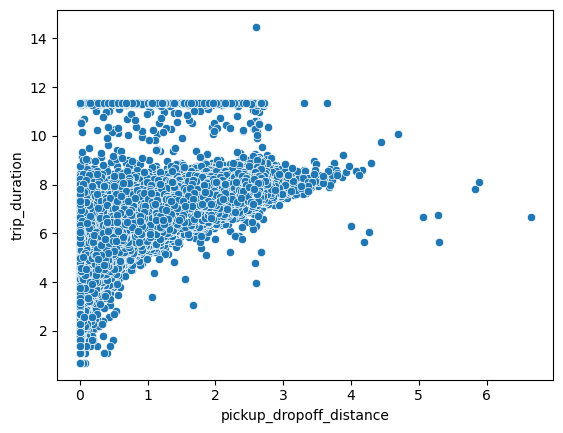

In [42]:
sns.scatterplot(x= 'pickup_dropoff_distance', y= 'trip_duration', data= numerical)

In [43]:
numerical['trip_duration'].sort_values(ascending=False)

21813     14.478063
259437    11.366650
119185    11.366604
177225    11.366500
496391    11.366488
            ...    
672240     0.693147
102646     0.693147
533760     0.693147
512833     0.693147
622664     0.693147
Name: trip_duration, Length: 729322, dtype: float64

We see certain values capped around values close to 11.5. Exponential transformation of these log values give trip_duration in and around ~86000. **86000 seconds correspond to 1 day**. While exploring outliers, it might be interesting to see if these are simply instances of the drop-off time incorrectly recording the next day. 

For example a trip started on Jan-1 9 PM and ended on Jan-1 9:05 PM is only 5 minutes. But if the drop-off time is erroneously recorded as Jan-2 9:05 PM, it may calculate a trip duration of more than 86000 seconds. 

We can revisit this later.

Now, let us see the scatterplot for the absolute values of trip duration and distance, but this time, let us use the **speed_data** which we created earlier after removing outliers.

<Axes: xlabel='pickup_dropoff_distance', ylabel='trip_duration'>

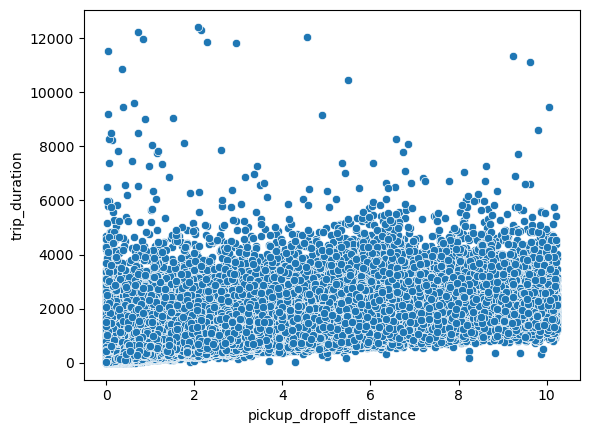

In [44]:
sns.scatterplot(x= 'pickup_dropoff_distance', y= 'trip_duration', data= speed_data)

In [45]:
speed_data['pickup_dropoff_distance'].corr((speed_data['trip_duration']))

0.7211390511229411

It looks like the correlation between distance and trip_duration has significantly increased simply by removing outliers from the trip_duration and distance. 

### Pick-up Vs Drop-off

<Axes: xlabel='pickup_latitude', ylabel='dropoff_latitude'>

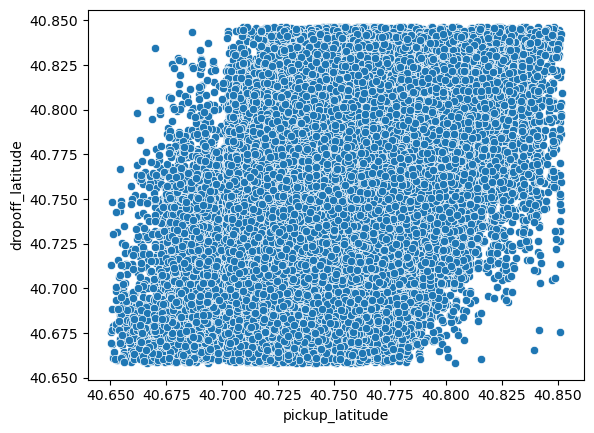

In [46]:
sns.scatterplot(x= 'pickup_latitude', y= 'dropoff_latitude', data= gps_data)

Nothing interesting to see here.

<Axes: xlabel='pickup_longitude', ylabel='dropoff_longitude'>

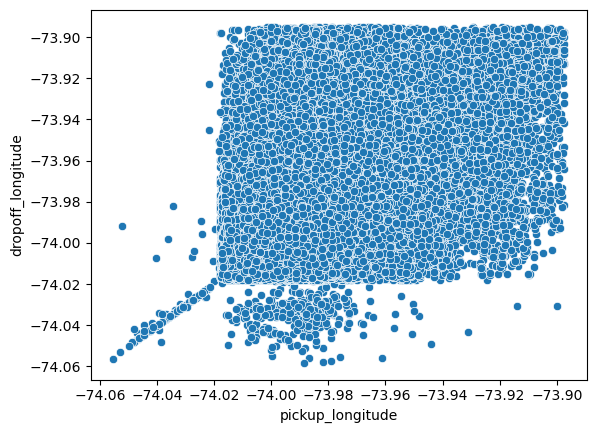

In [47]:
sns.scatterplot(x= 'pickup_longitude', y= 'dropoff_longitude', data= gps_data)

Strong linear relationship between the pick-up and drop-off longitudes for the range (-74.06, -74.02) indicate that trips that are initiated within these coordinates could be short trips. For coordinates > -74.02, there are drop-offs across all the coordinates as can be inferred from the dense plot. 

### Pickup time vs trip-duration

Here we can explore how the trip duration varies with pickup time (month, week & hour). Since we have outliers in trip duration, we will look at the median value.

<Axes: xlabel='month_pickup', ylabel='trip_duration'>

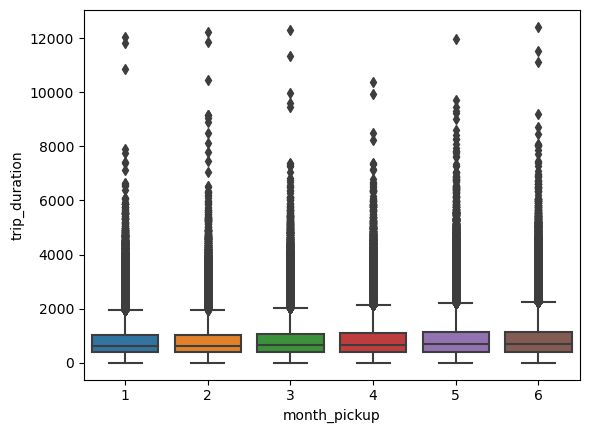

In [48]:
temp_data= data[data['trip_duration'] < (data['trip_duration'].mean() + 3*data['trip_duration'].std())]
sns.boxplot(x='month_pickup', y= 'trip_duration', data=temp_data)

In [49]:
def medianplot(feature_list, figsize= (10,5)):
    
    size= len(feature_list)
    plt.figure(figsize = (8*size,5), dpi = 100)
    for j,i in enumerate(feature_list):
        x= data.groupby(i)['trip_duration'].median().index
        y= data.groupby(i)['trip_duration'].median().values
        plt.subplot(1,size,j+1)

        ax=sns.barplot(x=x, y=y)
        
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('Median trip duration')
        for i in [0,1]:
            for p in ax.patches:
                ax.annotate('{:1.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                            ha='center', va='bottom',
                            color= 'black')
    plt.tight_layout()
    plt.show()

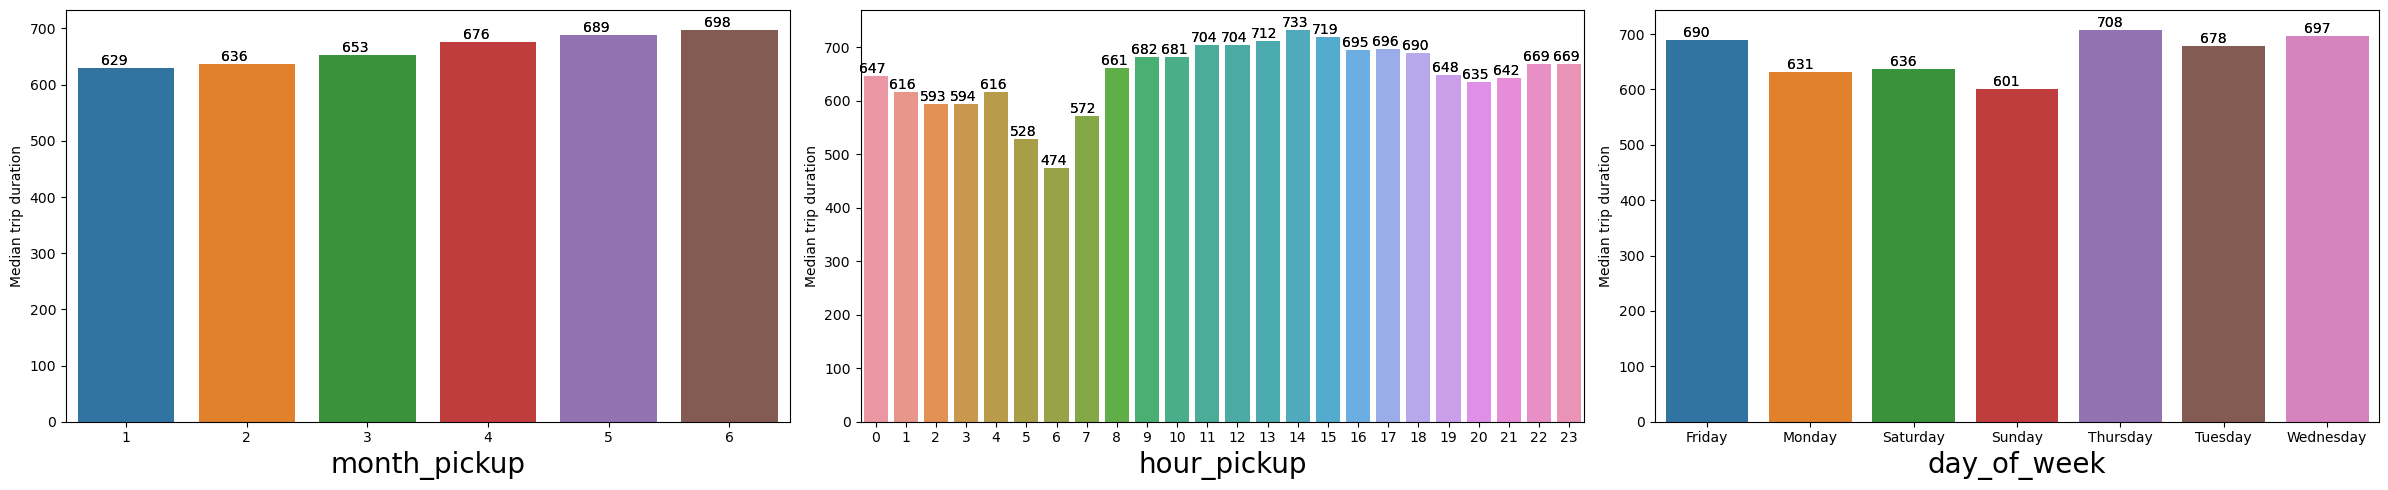

In [50]:
medianplot(["month_pickup",'hour_pickup','day_of_week'])

1. The median trip duration is consistently going up from January to June. It is not clear why that is the case and may need further investigation in multi-variate analysis.

2. The median trip duration peaks at around 2 PM. So the busiest times are around noon till evening. It maybe worthwhile to map the hours to time of the day and see the variability i.e., create categories such as early morning, morning, noon, evening & late night

3. Sunday has the lowest trip duration which maybe due to less traffic density. But it is not clear why thursday has the highest median trip duration. 


In [51]:
quant25 = data['trip_duration'].quantile(0.25)
quant75 = data['trip_duration'].quantile(0.75)
IQR = quant75 - quant25
lower_bound = quant25-(1.5*IQR)
upper_bound = quant75+(1.5*IQR)
temp_data= data[(data['trip_duration']>lower_bound) & (data['trip_duration']< upper_bound)]


<Axes: xlabel='month_pickup', ylabel='trip_duration'>

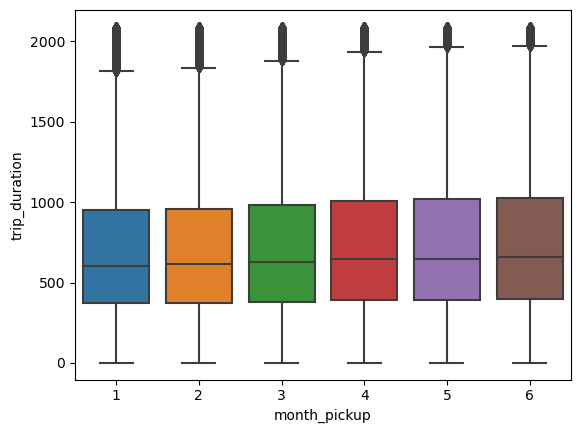

In [52]:
sns.boxplot(x='month_pickup', y= 'trip_duration', data=temp_data)

<Axes: xlabel='day_of_week', ylabel='trip_duration'>

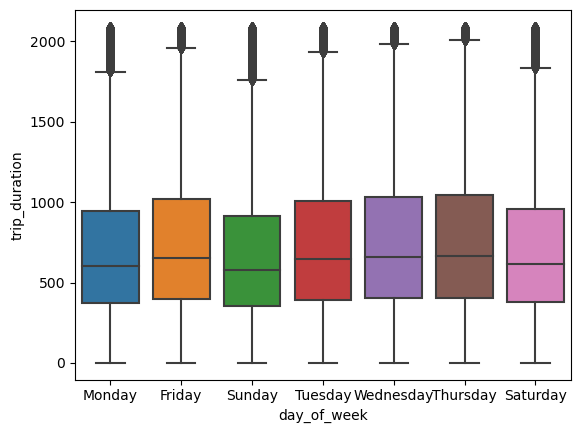

In [53]:
sns.boxplot(x='day_of_week', y= 'trip_duration', data=temp_data)

<Axes: xlabel='hour_pickup', ylabel='trip_duration'>

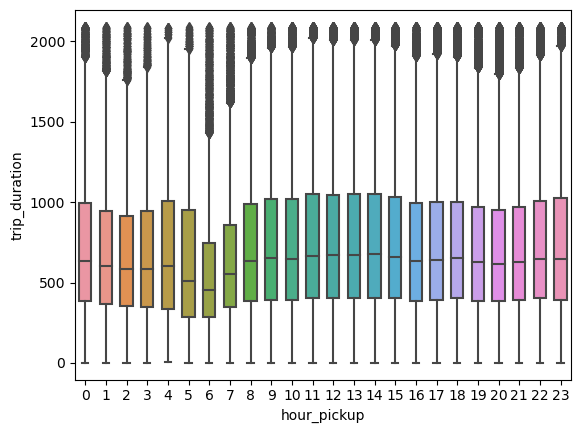

In [54]:
sns.boxplot(x='hour_pickup', y= 'trip_duration', data=temp_data, width=0.6)

Too many points beyond the 75th quantile for every hour of the day across Month, week and hour, despite filtering out data beyond the upper bound (1.5*IQR above 75th quantile).

Hence, it may be difficult to infer anything solid from these three variables and their relationship with median trip duration, without systematically removing the outliers.

### Bivariate analysis: Continuous- Categorical variables

The hypotheses we will test are as follows:
- Is there statistically significant difference in avg trip durations of vendor-id 1&2.
- When store_and_fwd_flag= 'Yes', it means the driver did not have connection to internet. Could this be instances of bad weather and hence, do these trips have higher trip duration?

For simplicity, we assume normal distribution of the data. Since we have extremely large sample, this should be ok.

In [55]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

In [56]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import t as t_dist
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval

In [57]:
def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.std()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot(x= [str(category),'not {}'.format(category)], y=[m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')
  

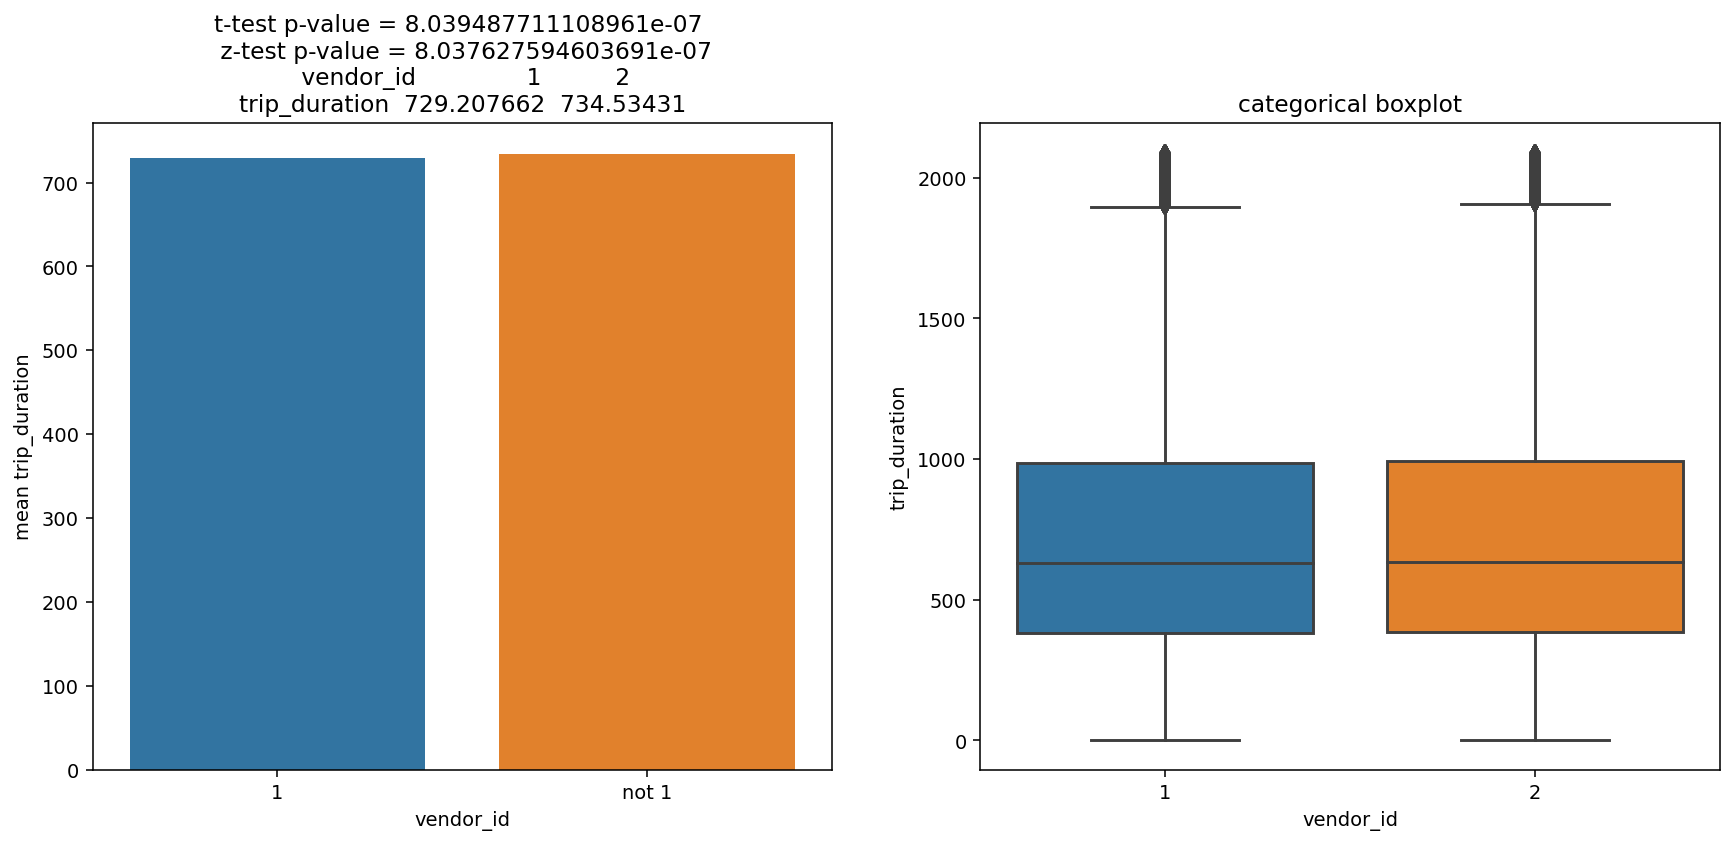

In [58]:
#temp_data= data[data['trip_duration'] < (data['trip_duration'].mean() + 2*data['trip_duration'].std())]
Bivariate_cont_cat(temp_data, 'trip_duration', 'vendor_id', 1)

The p-value is extremely low. So, vendor-id may have an impact.

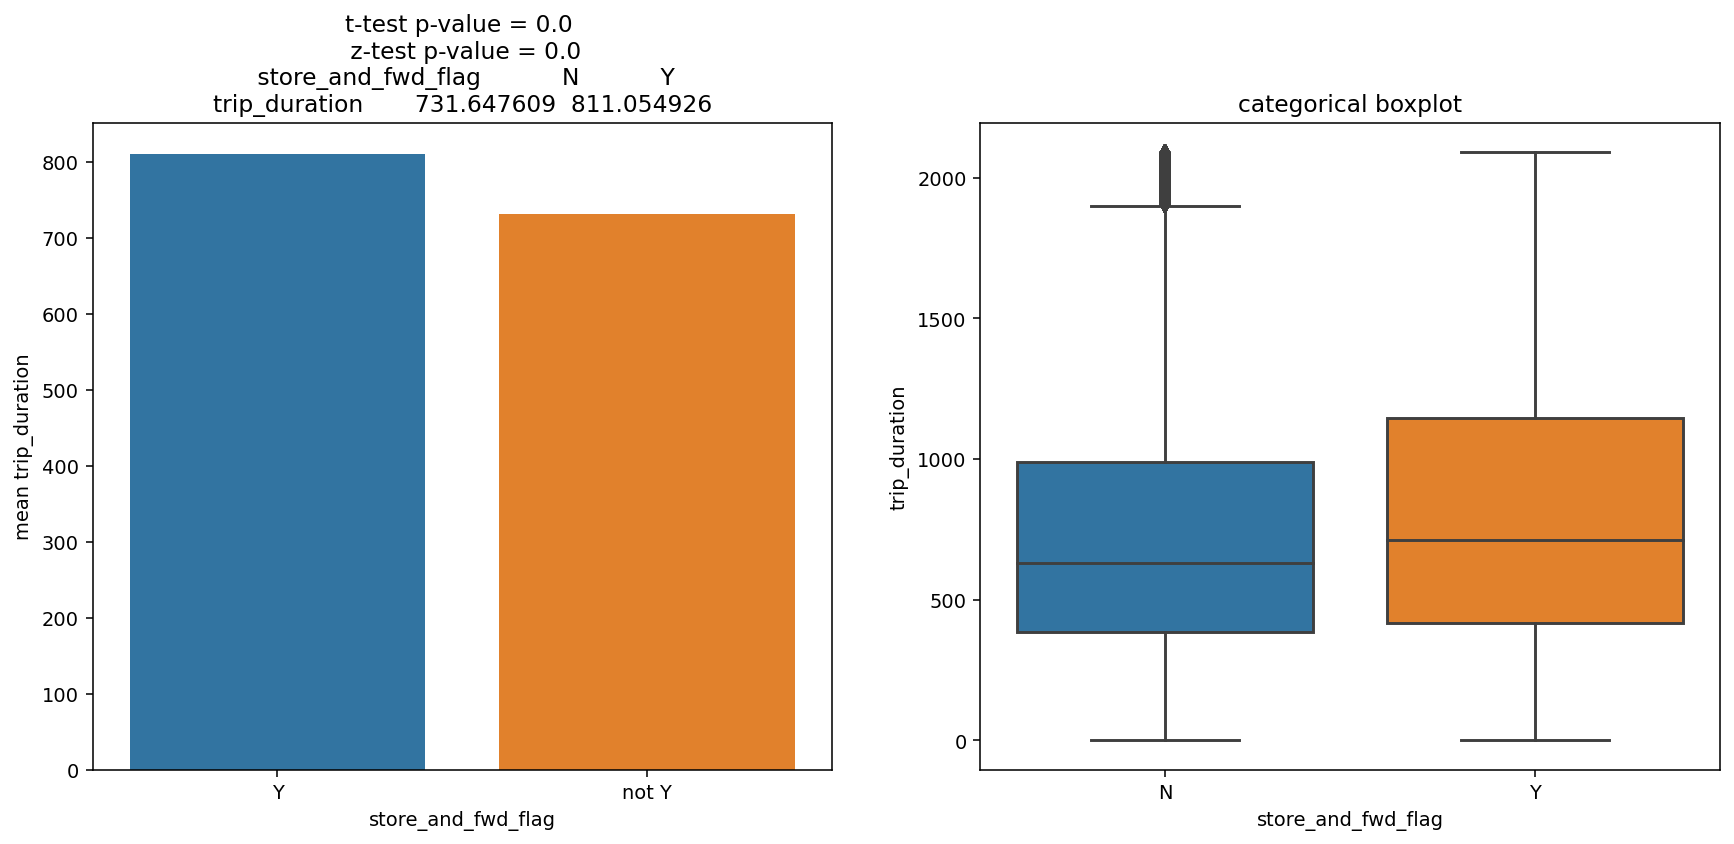

In [59]:
Bivariate_cont_cat(temp_data, 'trip_duration', 'store_and_fwd_flag', 'Y')

The trips with store_and_fwd_flag='Y' does have a higher average time.

### Feature engineering by clustering of latitude and longitude

As discussed above, we can cluster the latitudes and longitudes since it makes sense from a geographical perspective.

A __k-means clustering__ approach may work for this purpose. We can create clusters for the pickup and destination, create origin-destination cluster pairs as a third variable and then assess trip-durations.

Since k-means clustering is susceptible to outliers, we will use the gps_data we earlier employed in the univariate analysis for this purpose.

In [60]:
from sklearn.cluster import KMeans

In [61]:
gps_pickup= gps_data[['pickup_longitude', 'pickup_latitude']]
gps_dropoff= gps_data[['dropoff_longitude', 'dropoff_latitude']]

In [62]:
wcss= [] #within-cluster sum of squares

for i in range(2,11):#let us experiment with anywhere between 2 to 10 clusters
    
    kmeans= KMeans(n_clusters=i,init='k-means++', random_state=42)
    kmeans.fit(gps_pickup)
    wcss.append(kmeans.inertia_)



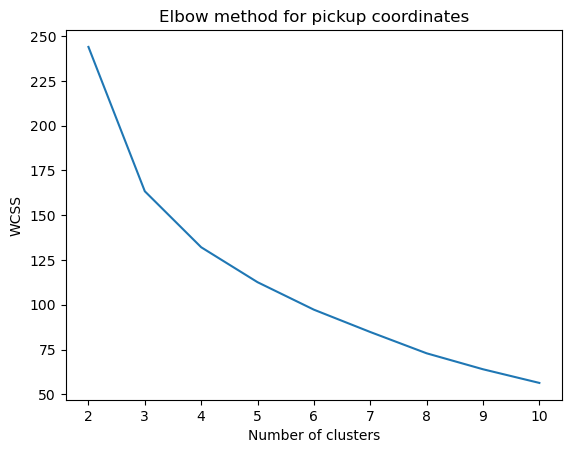

In [63]:
plt.plot(range(2,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.title('Elbow method for pickup coordinates')
plt.show()

In [64]:
wcss= [] #within-cluster sum of squares

for i in range(2,11):#let us experiment with anywhere between 2 to 10 clusters
    
    kmeans= KMeans(n_clusters=i,init='k-means++', random_state=42)
    kmeans.fit(gps_dropoff)
    wcss.append(kmeans.inertia_)

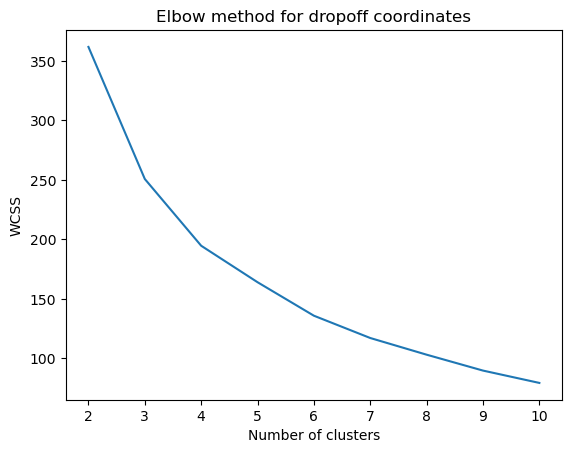

In [65]:
plt.plot(range(2,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.title('Elbow method for dropoff coordinates')
plt.show()

4 may be a good number of clusters for both pickup and drop-off.

In [66]:
pickup_cluster= KMeans(n_clusters=4, init='k-means++',random_state=42)
gps_data['pickup_cluster']= pickup_cluster.fit_predict(gps_pickup)
gps_data['pickup_cluster']
pickup_centers=pickup_cluster.cluster_centers_

In [67]:
dropoff_cluster= KMeans(n_clusters=4, init='k-means++',random_state=42)
gps_data['dropoff_cluster']= dropoff_cluster.fit_predict(gps_dropoff)
dropoff_centers= dropoff_cluster.cluster_centers_

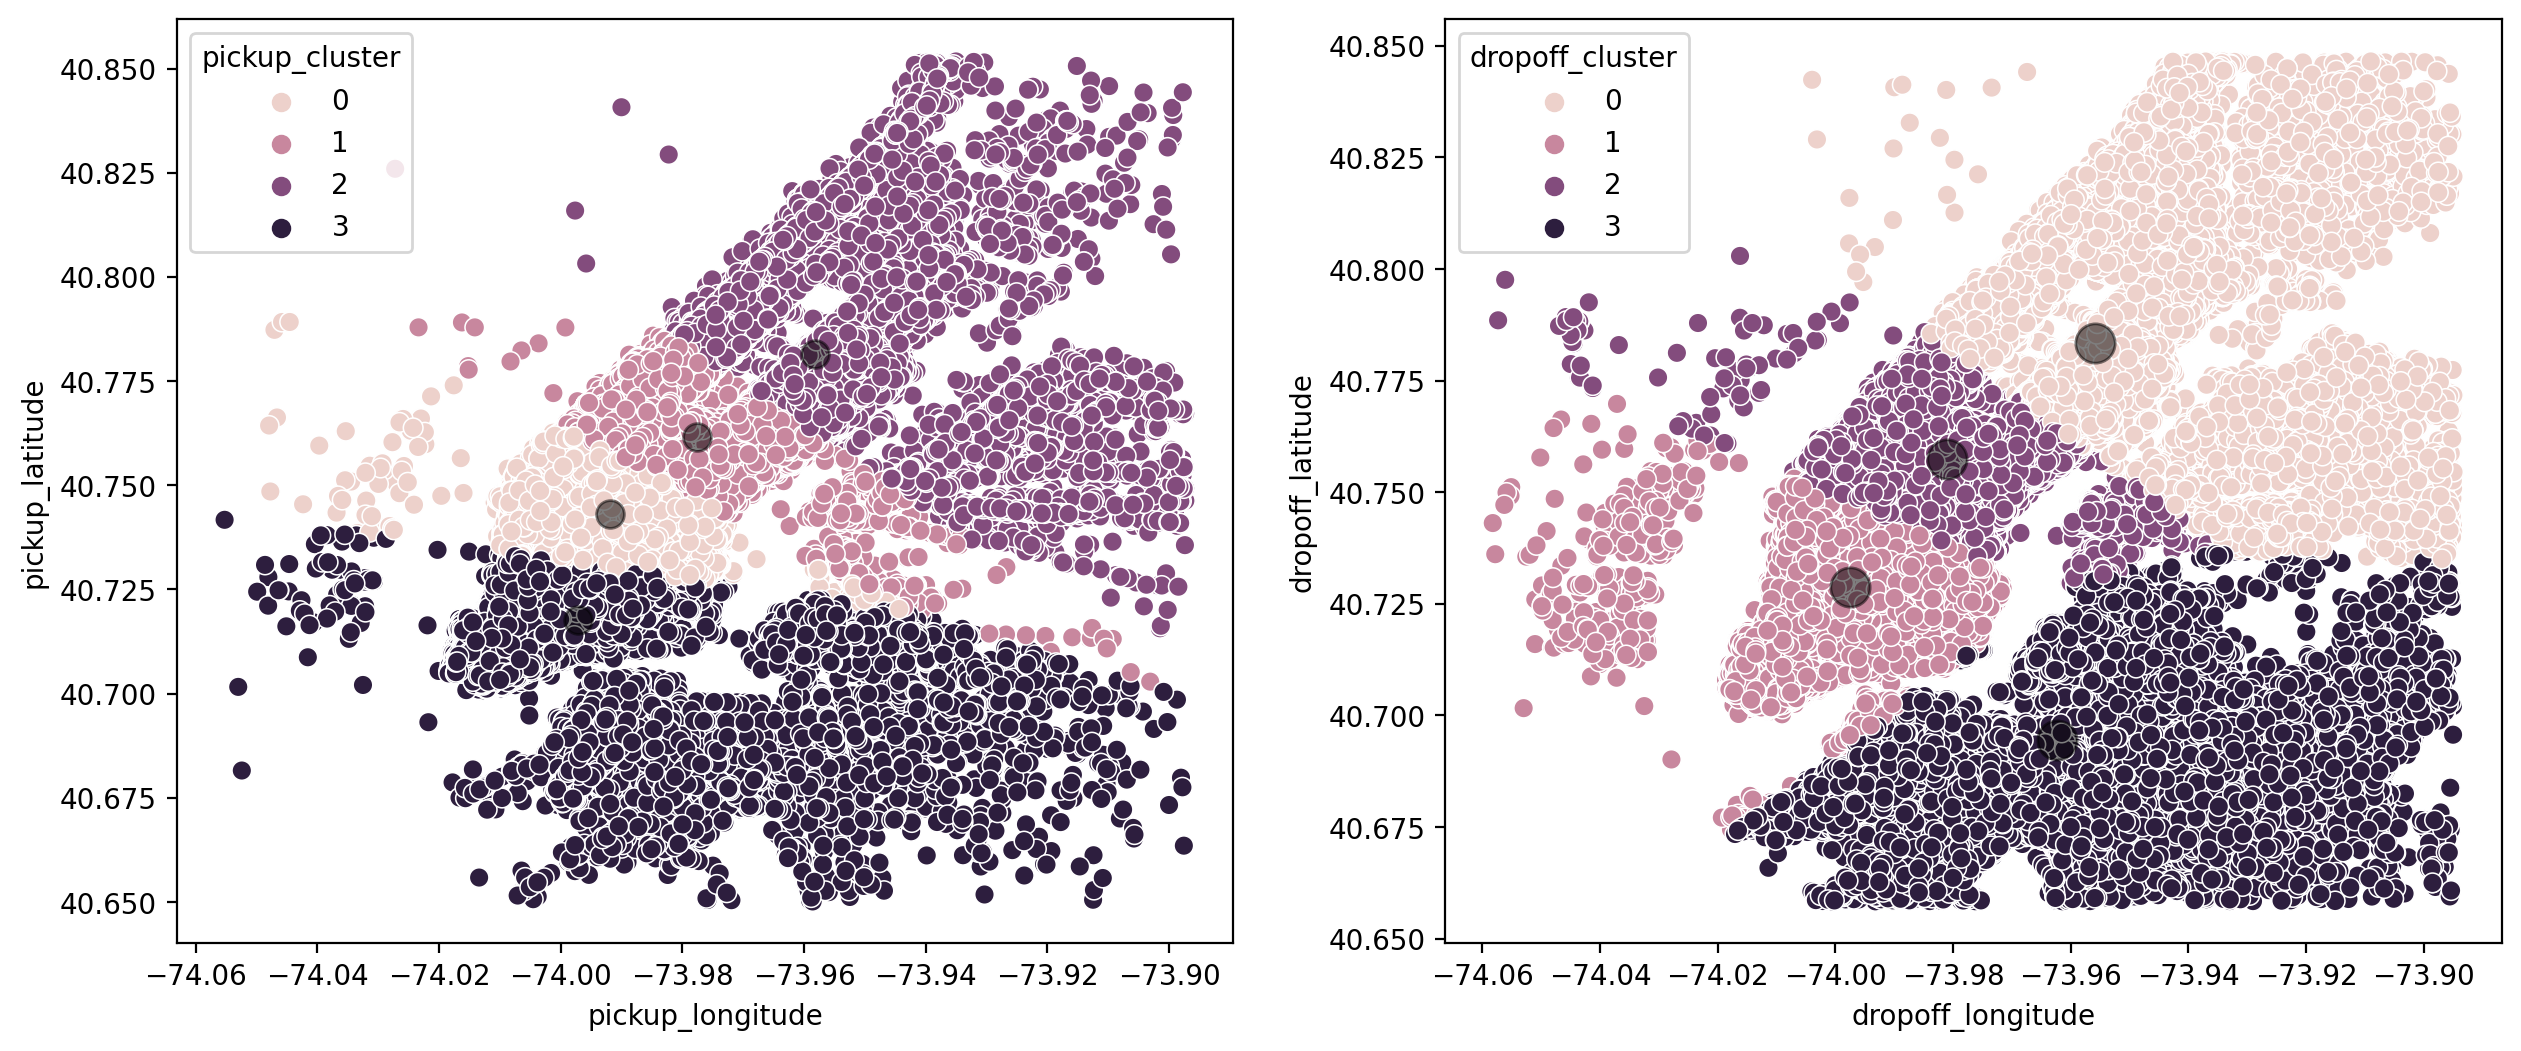

In [68]:
plt.figure(figsize = (15,6), dpi=200)
plt.subplot(1,2,1)
sns.scatterplot(data= gps_data, x = 'pickup_longitude', y = 'pickup_latitude', hue='pickup_cluster', s=50, cmap='viridis')
plt.scatter(pickup_centers[:, 0], pickup_centers[:, 1], c='black', s=100, alpha=0.5)
plt.subplot(1,2,2)
sns.scatterplot(data= gps_data,x = 'dropoff_longitude', y = 'dropoff_latitude', hue='dropoff_cluster', s=50, cmap='viridis')
plt.scatter(dropoff_centers[:, 0], dropoff_centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [69]:
new_gps_data= pd.merge(gps_data, data[['trip_duration','pickup_dropoff_distance']], left_index=True, right_index=True,)
new_gps_data['trip_duration_hrs']= new_gps_data['trip_duration']/3600
new_gps_data

pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.953918        40.778873         -73.963875   
1             -73.988312        40.731743         -73.994751   
2             -73.997314        40.721458         -73.948029   
3             -73.961670        40.759720         -73.956779   
4             -74.017120        40.708469         -73.988182   
...                  ...              ...                ...   
729317        -73.965919        40.789780         -73.952637   
729318        -73.996666        40.737434         -74.001320   
729319        -73.997849        40.761696         -74.001488   
729320        -74.006706        40.708244         -74.013550   
729321        -74.003342        40.743839         -73.945847   

        dropoff_latitude  pickup_cluster  dropoff_cluster  trip_duration  \
0              40.771164               2                0            400   
1              40.694931               0                3           1100   
2              40.774918               3                0           1635   
3              40.780628               1                0           1141   
4              40.740631               3                1            848   
...                  ...             ...              ...            ...   
729317         40.789181               2                0            296   
729318         40.731911               0                1            315   
729319         40.741207               0                1            673   
729320         40.713814               3                1            447   
729321         40.712841               0                3           1224   

        pickup_dropoff_distance  trip_duration_hrs  
0                      0.745502           0.111111  
1                      2.562501           0.305556  
2                      4.505212           0.454167  
3                      1.465371           0.316944  
4                      2.689391           0.235556  
...                         ...                ...  
729317                 0.697842           0.082222  
729318                 0.452708           0.087500  
729319                 1.426618           0.186944  
729320                 0.526129           0.124167  
729321                 3.699200           0.340000  

[663117 rows x 9 columns]

In [70]:
new_gps_data.groupby(['pickup_cluster', 'dropoff_cluster']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

pickup_cluster  dropoff_cluster  counts
6                1                2  113042
2                0                2   91605
1                0                1   81411
8                2                0   78237
4                1                0   58536
13               3                1   55301
10               2                2   49103
5                1                1   38927
14               3                2   28812
0                0                0   21325
15               3                3   16227
9                2                1   10116
12               3                0    8236
3                0                3    6992
7                1                3    3946
11               2                3    1301

__Cluster 1 to cluster 2__ has the highest number of trips. If we see the map, we see this are in similar regions in both drop-off and pickup clusters. 

- Based on the map of New York,this region is close to Manhattan downtown, so a lot of short trips in this region contribute to the overall customer base- which could be short work trips, trips to restaurants/pubs as hypothesised earlier.
- Connectivity to cluster 3 (which makes up for the Brooklyn and parts of Queens regions) have the least number of trips, even though it makes up for a significant portion in terms of area.


### Calculating average speed in miles/hour between clusters

Since we are calculating average, let us remove the outliers.

In [71]:
quant25 = new_gps_data['trip_duration'].quantile(0.25)
quant75 = new_gps_data['trip_duration'].quantile(0.75)
IQR = quant75 - quant25
lower_bound = quant25-(1.5*IQR)
upper_bound = quant75+(1.5*IQR)
temp_data= new_gps_data[(new_gps_data['trip_duration']>lower_bound) & (new_gps_data['trip_duration']< upper_bound)]

In [72]:
temp_data.groupby(['pickup_cluster', 'dropoff_cluster']).\
apply(lambda x: x['pickup_dropoff_distance'].sum()/ x['trip_duration_hrs'].sum()).\
reset_index(name='grand_avg_speed_in_mph').sort_values(by='grand_avg_speed_in_mph', ascending=False)

pickup_cluster  dropoff_cluster  grand_avg_speed_in_mph
12               3                0               14.074897
11               2                3               13.117967
9                2                1               12.196453
7                1                3               11.165502
0                0                0               11.006996
3                0                3               10.036088
15               3                3                9.513704
14               3                2                9.347450
4                1                0                9.310877
5                1                1                8.733439
8                2                0                8.089193
10               2                2                7.674467
1                0                1                7.045785
13               3                1                6.766689
2                0                2                6.337177
6                1                2                5.427931

Cluster 3 to 0 has the highest avg speed based on all trips. This maybe because these trips do not touch the city regions like Downtown Manhattan.

## Multi-Variate Analysis

### Months, Weeks, Hours Vs Median trip duration

We will continue to use the same temp_data with outlier trip durations removed.

In [73]:
new_temp_data= pd.merge(temp_data, data[['month_pickup','hour_pickup','day_of_week']], left_index=True, right_index=True,)

In [74]:
summary= new_temp_data.groupby(['month_pickup','day_of_week']).agg(total_trips=('month_pickup','size'), total_distance= ('pickup_dropoff_distance','sum'), median_trip_duration= ('trip_duration','median')).reset_index().sort_values(by='median_trip_duration',ascending=False)
summary

month_pickup day_of_week  total_trips  total_distance  \
32             5    Thursday        14392    20438.689816   
34             5   Wednesday        14018    20069.410645   
41             6   Wednesday        16875    24077.569333   
39             6    Thursday        17569    25290.188518   
28             5      Friday        14655    21175.706381   
25             4    Thursday        14690    20971.235364   
35             6      Friday        14281    20911.670999   
21             4      Friday        19093    27618.650175   
33             5     Tuesday        17025    24251.989820   
27             4   Wednesday        14390    20973.996684   
40             6     Tuesday        13259    19087.064106   
26             4     Tuesday        14342    20640.685692   
18             3    Thursday        18489    27225.812566   
14             3      Friday        15788    23253.883513   
20             3   Wednesday        18096    26601.278269   
13             2   Wednesday        14627    20721.133932   
4              1    Thursday        14320    20870.144756   
37             6    Saturday        14546    22929.619134   
11             2    Thursday        15449    21975.231324   
7              2      Friday        15743    22591.076536   
12             2     Tuesday        13880    19617.207954   
30             5    Saturday        15390    24047.725092   
19             3     Tuesday        17398    25142.228535   
6              1   Wednesday        13904    19774.889546   
5              1     Tuesday        12994    18257.337240   
36             6      Monday        12392    18427.904422   
16             3    Saturday        16613    26037.265447   
23             4    Saturday        20685    31927.574995   
0              1      Friday        18337    27205.027633   
22             4      Monday        13217    19456.486372   
9              2    Saturday        16668    25424.817693   
29             5      Monday        15268    23169.268930   
2              1    Saturday        15740    23968.757150   
38             6      Sunday        12457    20295.396701   
15             3      Monday        13258    19145.247789   
24             4      Sunday        14091    22734.973310   
8              2      Monday        16051    23820.835463   
31             5      Sunday        16734    27007.088201   
10             2      Sunday        14234    22606.839155   
1              1      Monday        11975    17058.740143   
17             3      Sunday        13900    22302.385823   
3              1      Sunday        14438    22779.707344   

    median_trip_duration  
32                 654.5  
34                 654.0  
41                 652.0  
39                 649.0  
28                 647.0  
25                 646.0  
35                 642.0  
21                 638.0  
33                 634.0  
27                 631.5  
40                 629.0  
26                 624.0  
18                 624.0  
14                 612.0  
20                 611.0  
13                 607.0  
4                  606.0  
37                 605.0  
11                 604.0  
7                  600.0  
12                 597.0  
30                 596.0  
19                 595.0  
6                  593.0  
5                  593.0  
36                 591.5  
16                 591.0  
23                 590.0  
0                  586.0  
22                 586.0  
9                  581.0  
29                 575.5  
2                  568.0  
38                 561.0  
15                 560.0  
24                 551.0  
8                  550.0  
31                 548.0  
10                 539.0  
1                  538.0  
17                 536.0  
3                  530.5

The lowest value in median trip duration is mostly seen on sundays and mondays of most month.

Across the months, we also see highest values in median trip duration on thursdays and fridays. Especially in the months April, May and June which make up all the high median trip duration combinations.

<Axes: xlabel='hour_pickup', ylabel='day_of_week'>

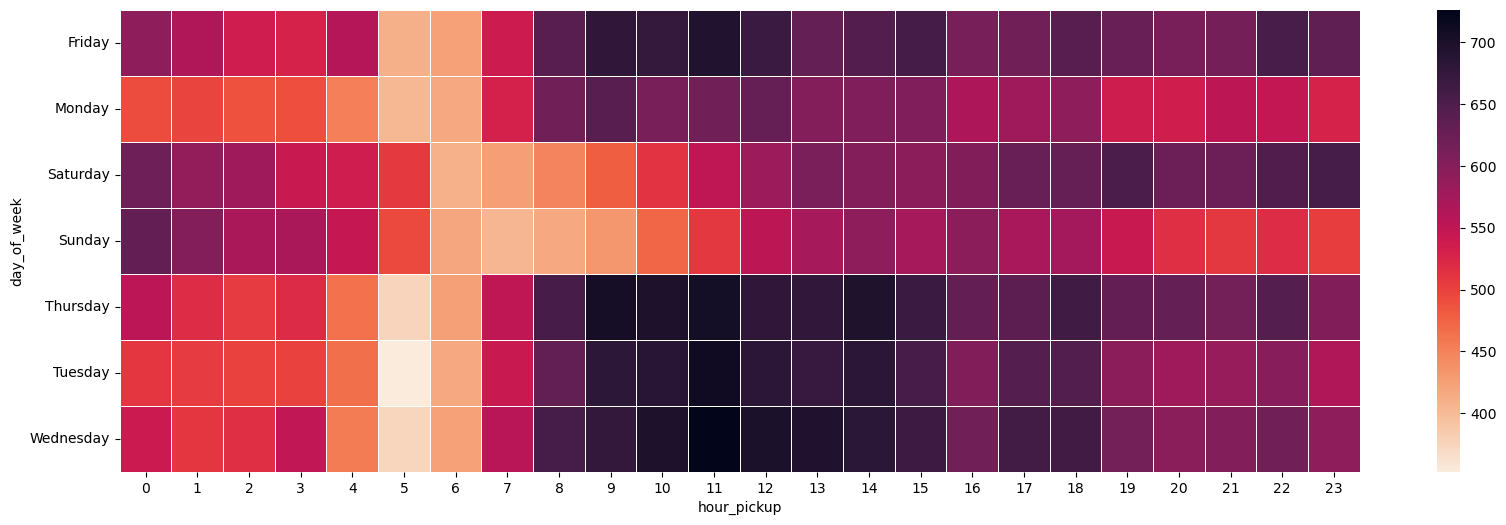

In [75]:
summary= new_temp_data.groupby(['day_of_week', 'hour_pickup']).agg(total_trips=('day_of_week','size'), total_distance= ('pickup_dropoff_distance','sum'), median_trip_duration= ('trip_duration','median')).reset_index().sort_values(by='median_trip_duration',ascending=False)

duration_pivot= pd.pivot_table(summary, index= 'day_of_week', values='median_trip_duration', columns='hour_pickup')
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(duration_pivot, linewidths=.5, ax=ax,cmap= sns.cm.rocket_r)

- On Saturdays and sundays, late nights have longer trips.
- On weekdays, especially on tuesdays, wednesdays and thursdays, we see high trip durations during the office hours.
- The trip durations are the shortest in early morning for every day of the week.

### Pickup-dropoff clusters Vs Median trip duration

<Axes: xlabel='hour_pickup', ylabel='pickup_cluster'>

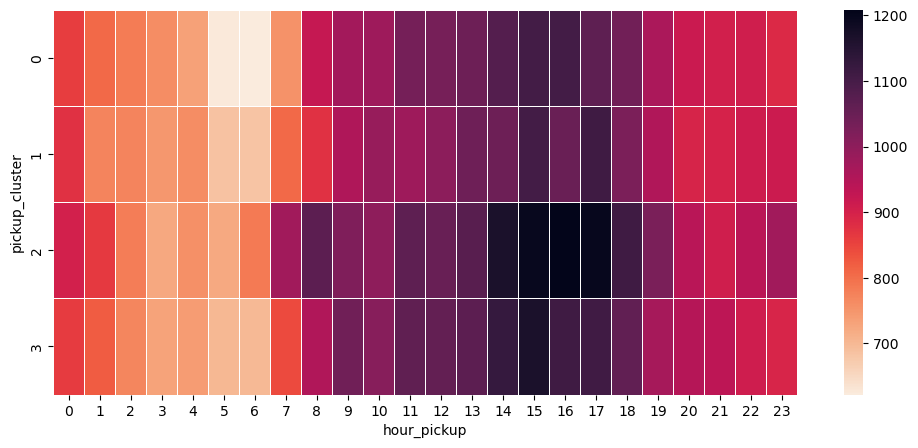

In [76]:
cluster_pivot_data= pd.merge(new_gps_data,data[['hour_pickup']], left_index=True, right_index=True,)
cluster_summary= cluster_pivot_data.groupby(['pickup_cluster', 'dropoff_cluster','hour_pickup']).agg( median_trip_duration= ('trip_duration','median')).reset_index()

cluster_pivot= pd.pivot_table(cluster_summary, index= ['pickup_cluster'], values='median_trip_duration', columns='hour_pickup')
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(cluster_pivot, linewidths=.5, ax=ax,cmap= sns.cm.rocket_r)

- Pickup from cluster 2 lead to the longest trips based on median trip duration
- Again, irrespective of the cluster of pickup, the duration is shorter during mornings

<Axes: xlabel='hour_pickup', ylabel='dropoff_cluster'>

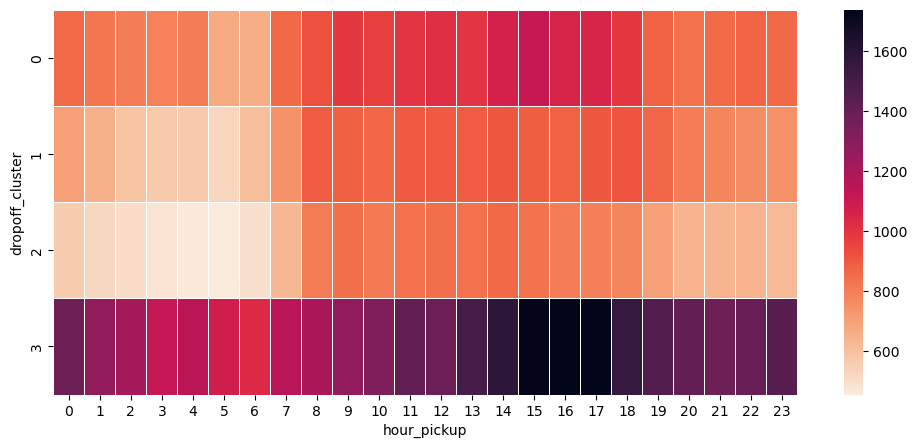

In [77]:
cluster_pivot= pd.pivot_table(cluster_summary, index= ['dropoff_cluster'], values='median_trip_duration', columns='hour_pickup')
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(cluster_pivot, linewidths=.5, ax=ax,cmap= sns.cm.rocket_r)

- Drop-off in cluster 3 are longer trips throughout the day. It is interesting to note that even during mornings, the drop-off is relatively longer than the drop-offs in the busiest hours of other clusters. 
- During work hours, in drop-off clusters in downtown, the median drop-off time is consistently in the ~800-1000 seconds range as shown by the color coding.

### Removing outliers

 The following conditions represent some of the very obvious unrealistic scenarios and such data points can be removed.
 
1. __Speed>120__: New york city speed limits is 25 mph. Anything beyond 120, even for very short durations, presents an unrealistic scenario.
<br>

2. __Pickup and drop-off same__: These may actually be trips that got cancelled but the meter that stores the drop-off time did not get disengaged till some time later thereby recording some trip duration. Or it could also be trips where the map was disabled from the pickup location thereby not capturing the drop-off location. It maybe hard to correctly identify those drop-off coordinates. If this is a small set of rows, it may be better to remove them.
<br>

3. __Distance <10__ and time spent more than 20k seconds: This would mean spending ~5.5 hours for a trip of less than 10 miles.
<br>

4. __Duration of trip < 10 seconds__: It seems unlikely a scenario that someone would book a cab for a trip that lasts less than 10 seconds.
<br>
5. __Latitude and longitude based on standard deviations from mean__: Assuming this is a local taxi service catering to areas in and around New York, we should be able to find some upper and lower bounds on the latitude and longitude for latitude and longitude. 3 Standard deviation can be an acceptable criteria.
<br>


In [78]:
remove_outlier_data= data.copy()
len(remove_outlier_data)

729322

In [79]:
#speed>120
remove_outlier_data= remove_outlier_data.drop(remove_outlier_data[data['avg_speed']>120].index)
len(remove_outlier_data), len(data)

(729286, 729322)

In [80]:
#pickup and drop-off same:
remove_outlier_data= remove_outlier_data.drop(remove_outlier_data[(remove_outlier_data['pickup_latitude']==remove_outlier_data['dropoff_latitude'])& (remove_outlier_data['pickup_longitude']==remove_outlier_data['dropoff_longitude'])].index)
len(remove_outlier_data)

726385

In [81]:
#distance less than 10 miles and trip duration >30000
remove_outlier_data= remove_outlier_data.drop(remove_outlier_data[(remove_outlier_data['pickup_dropoff_distance']<10)& (remove_outlier_data['trip_duration']>20000)].index)
len(remove_outlier_data)

725436

In [82]:
#remove trips with trip duration<10 seconds
remove_outlier_data= remove_outlier_data.drop(remove_outlier_data[remove_outlier_data['trip_duration']<10].index)
len(remove_outlier_data)

724773

In [83]:
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude']:
    print(max(remove_outlier_data[i]), min(remove_outlier_data[i]))
    
    

-72.07433319091797 -121.93334197998048
41.31916427612305 35.310306549072266
-72.02240753173828 -121.9333038330078
41.48075485229492 35.173545837402344


We still have extreme coordinate values which may not be representative of New York City.
Let us remove every data point with coordinate 3 SD away from mean.

In [84]:
factor=3
remove_outlier_data = remove_outlier_data[(remove_outlier_data['pickup_latitude'] < (remove_outlier_data['pickup_latitude'].mean() + factor*remove_outlier_data['pickup_latitude'].std()))
                   & (remove_outlier_data['pickup_latitude'] > (remove_outlier_data['pickup_latitude'].mean() - factor*remove_outlier_data['pickup_latitude'].std()))]
remove_outlier_data = remove_outlier_data[(remove_outlier_data['pickup_longitude'] < (remove_outlier_data['pickup_longitude'].mean() + factor*remove_outlier_data['pickup_longitude'].std()))
                   & (remove_outlier_data['pickup_longitude'] > (remove_outlier_data['pickup_longitude'].mean() - factor*remove_outlier_data['pickup_longitude'].std()))]
remove_outlier_data = remove_outlier_data[(remove_outlier_data['dropoff_latitude'] < (remove_outlier_data['dropoff_latitude'].mean() + factor*remove_outlier_data['dropoff_latitude'].std()))
                   & (remove_outlier_data['dropoff_latitude'] > (remove_outlier_data['dropoff_latitude'].mean() - factor*remove_outlier_data['dropoff_latitude'].std()))]
remove_outlier_data = remove_outlier_data[(remove_outlier_data['dropoff_longitude'] < (remove_outlier_data['dropoff_longitude'].mean() + factor*remove_outlier_data['dropoff_longitude'].std()))
                   & (remove_outlier_data['dropoff_longitude'] > (remove_outlier_data['dropoff_longitude'].mean() - factor*remove_outlier_data['dropoff_longitude'].std()))]

len(remove_outlier_data)

658389

In [86]:
numerical_cols= [cols for cols in remove_outlier_data.columns if (remove_outlier_data[cols].dtypes== 'int') | (remove_outlier_data[cols].dtypes== 'float64')]
for col in numerical_cols:
    print(f"The range of {col}: [{remove_outlier_data[col].min()}, {remove_outlier_data[col].max()}]")

The range of passenger_count: [0, 6]
The range of pickup_longitude: [-74.05240631103516, -73.90090942382812]
The range of pickup_latitude: [40.66392135620117, 40.83795166015625]
The range of dropoff_longitude: [-74.05782318115234, -73.89524078369139]
The range of dropoff_latitude: [40.65988159179688, 40.84489822387695]
The range of trip_duration: [10, 18439]
The range of month_pickup: [1, 6]
The range of hour_pickup: [0, 23]
The range of minute_pickup: [0, 59]
The range of pickup_dropoff_distance: [0.0002632206006997537, 11.358082049547027]
The range of avg_speed: [0.0012702508375994248, 97.81711688404734]


We ended up going from 729322 to 658389 data points which is ~10% elimination of data. But based on the criteria we selected, these may be real outliers.

The ranges of values also look reasonable.

With this we conclude our EDA.